## **Exploratory Data Analysis of Weather Conditions and Solar Panel Efficiency**
### **Overview of Process:**
1) Load data from database
   * To import data from databased for analysis
   
2) Inspect dataset
   * To get an overview of the dataset's structure, size, type of variables (numerical or categorical) and their data types.

3) Ouality Check
   * To check dataset for incorrect data type, missing values, duplicated entries, inconsistent naming (catergorical variables) and other typos.
   * Variable with incorrect data types are converted to their correct types.
   * Missing values for numerical variables are filled in with their median. There is no missing value in the categorical variables of this dataset.
   * Duplicates are deleted from the dataset.
   * Categorical variables with inconsistent naming are corrected and standardised.

4) Descriptive Statistics
   * Numerical variable:
     * Generate descriptive statistics.
     * Explore distribution
   * Categorical variable:
     * Explore distribution

5) Explore relationship between X variables
   Check for the existence of relationship between the X variables.
   * Compute correlation. Highly correlated variables can be removed.

6) Explore the relationship between X variables and Y variable.
   Check for the existence of relationship between each of the X variables and Y variable.
   * Graphical visualization (e.g Boxplot, stacked barcharts)
   * Statistical test (e.g Chi Square test of independence)

In [172]:
# Import required libraries.
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [173]:
# Function for renaming wind direction values.
def rename_wind_dir(x):
    if x in ['N','N.','north','NORTH','Northward']:
        return 'North'
    elif x in ['S','S.','south','SOUTH','Southward']:
        return 'South'
    elif x in ['E','E.','east','EAST']:
        return 'East'
    elif x in ['W','W.','west','WEST']:
        return 'West'
    elif x in ['NE','NE.','northeast','NORTHEAST']:
        return 'NorthEast'
    elif x in ['SE','SE.','southeast','SOUTHEAST']:
        return 'SouthEast'
    elif x in ['SW','SW.']:
        return 'SouthWest'
    elif x in ['NW','NW.','northwest','NORTHWEST']:
        return 'NorthWest'
    else:
        return x

In [174]:
# Function for renaming and regrouping dew point categories.
def rename_dew_pt(x):
    if x in ['Very High','High','High Level','H','HIGH','high','very high','VERY HIGH','VH','Extreme']:
        return 'High'
    elif x in ['moderate','Normal','MODERATE','M','Moderate']:
        return 'Moderate'
    elif x in ['Very Low','Low','LOW','VL','very low','low','L','VERY LOW','Below Average','Minimal']:
        return 'Low'

In [175]:
# Function for tabulating the raw counts and %counts of solar panel efficiency levels across catergory variables.
def cross_table(series1, series2):
    xtable = pd.crosstab(series1, series2)
    cols = xtable.columns.to_list()
    
    xtable['Total'] = xtable[cols].sum(axis=1)
    
    for f in cols:
        xtable[f+'(%)'] = (xtable[f]/xtable['Total'])*100

    return xtable

### 1. **Data Loading & Inspection**
The purpose of this step are as follow:
1) To load data from database.
2) Get an overview of the datasets.

In [176]:
con = sqlite3.connect("data/air_quality.db")
air = pd.read_sql_query("SELECT * from air_quality", con)

In [177]:
con = sqlite3.connect("data/weather.db")
weather = pd.read_sql_query("SELECT * from weather", con)

In [178]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data_ref      3875 non-null   object
 1   date          3875 non-null   object
 2   pm25_north    3836 non-null   object
 3   pm25_south    3836 non-null   object
 4   pm25_east     3836 non-null   object
 5   pm25_west     3836 non-null   object
 6   pm25_central  3836 non-null   object
 7   psi_north     3836 non-null   object
 8   psi_south     3836 non-null   object
 9   psi_east      3836 non-null   object
 10  psi_west      3836 non-null   object
 11  psi_central   3836 non-null   object
dtypes: object(12)
memory usage: 363.4+ KB


All variables in the air dataframe are in string data types. They need to be converted to datatime and float datatypes.

In [179]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3517 non-null   object 
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object 
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object 
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object 
 6   Min Temperature (deg C)        3517 non-null   object 
 7   Maximum Temperature (deg C)    3517 non-null   object 
 8   Min Wind Speed (km/h)          3517 non-null   object 
 9   Max Wind Speed (km/h)          3502 non-null   object 
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Wet Bulb Temperature (deg F)   3517 non-null   f

Many variables in the weather dataframe are in string data types. They need to be converted to datatime and float datatypes.

### 2. **Data Cleaning & Processing**
The purpose of this step are as following:
1) To convert variables into their correct datatypes.
2) Check for and remove duplicate entries.
3) Merge the air and weather dataframes to form 1 dataframe.
4) Check for and fill in missing values.
5) Check for and resolve inconsistent entries (e.g wind direction & dew point features)
6) Remove unnecessary columns (e.g data_ref).

**2.1 Convert date to datetime**

In [180]:
# Convert date to datetime so that the 2 dataframes can be merged on data.
air['date'] = pd.to_datetime(air['date'], dayfirst=True)
weather['date'] = pd.to_datetime(weather['date'], dayfirst=True)

In [181]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   data_ref      3875 non-null   object        
 1   date          3875 non-null   datetime64[ns]
 2   pm25_north    3836 non-null   object        
 3   pm25_south    3836 non-null   object        
 4   pm25_east     3836 non-null   object        
 5   pm25_west     3836 non-null   object        
 6   pm25_central  3836 non-null   object        
 7   psi_north     3836 non-null   object        
 8   psi_south     3836 non-null   object        
 9   psi_east      3836 non-null   object        
 10  psi_west      3836 non-null   object        
 11  psi_central   3836 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 363.4+ KB


In [182]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3517 non-null   object        
 1   date                           3517 non-null   datetime64[ns]
 2   Daily Rainfall Total (mm)      3517 non-null   object        
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object        
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object        
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object        
 6   Min Temperature (deg C)        3517 non-null   object        
 7   Maximum Temperature (deg C)    3517 non-null   object        
 8   Min Wind Speed (km/h)          3517 non-null   object        
 9   Max Wind Speed (km/h)          3502 non-null   object        
 10  Sunshine Duration (hrs)        3501 non-null   float64       
 11  Cloud Cover (%)  

Date variable in both dataframes have been converted to datatimes.

In [183]:
# Remove data_ref column.
air.drop('data_ref', axis=1, inplace=True)
weather.drop('data_ref', axis=1, inplace=True)

**2.2 Check for and remove duplicates for air dataset**

In [184]:
# Check for dupliated entries in air dataframe.
air.loc[air.duplicated()]

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
3158,2021-06-28,16,10,7,8,10,58,44,-,42,52
3159,2017-05-16,11,11,8,-,8,52,54,47,42,48
3160,2015-02-05,9,14,14,14,9,36,51,53,52,36
3161,2015-01-04,10,10,10,9,9,45,45,53,51,42
3162,2014-09-13,24,26,27,30,24,64,64,-,67,65
...,...,...,...,...,...,...,...,...,...,...,...
3792,2021-06-01,18,10,11,12,10,53,42,39,52,45
3793,2019-05-30,13,9,8,7,10,47,37,49,36,46
3794,2019-07-14,--,12,--,11,10,42,51,46,-,--
3795,2020-11-08,14,18,13,6,13,52,56,54,34,52


These are the rows with duplicated entries.They have to be remove from the dataframe before EDA analysis can be performed.

In [185]:
# Drop dulipcates and keep only the first one.
air.drop_duplicates(keep='first',ignore_index=True, inplace=True)
air.loc[air.duplicated()]

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central


All duplicates in the air dataframes are dropped. It is verified that there is no duplicate in the dataframe.

In [186]:
# Check for dates that are duplicated
air.loc[air['date'].duplicated()]

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
3197,2015-08-10,22,21,22,22,--,None,None,None,None,None
3198,2019-08-29,15,18,17,16,17,None,None,None,None,None
3199,2021-07-07,29,17,14,26,28,None,None,None,None,None
3200,2022-02-05,10,8,11,7,12,None,None,None,None,None
3201,2018-11-19,-,8,9,7,11,None,None,None,None,None
3202,2022-03-01,11,8,14,-,-,None,None,None,None,None
3203,2017-12-10,17,--,23,--,20,None,None,None,None,None
3204,2018-03-27,8,9,8,7,9,None,None,None,None,None
3205,2016-05-05,14,18,18,16,23,None,None,None,None,None
3206,2015-04-27,16,14,20,15,14,None,None,None,None,None


These are the dates that are duplicated. This means that there are more than 1 entry for a single date. These duplicated dates
need to be resolved, as they will caused problems when merging with the other dataframe.

In [187]:
# Take a look at the rows where date is duplicated.
air.loc[air['date']=='2015-08-10']

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
3158,2015-08-10,None,None,None,None,None,62,60,60,63,57
3197,2015-08-10,22,21,22,22,--,None,None,None,None,None


A check on one of the duplicated dates shows that they display a certain pattern. One row has no data on pm25, while the other 
row doesn't have data on psi. So, the way to resolve it is to combine them into a single row.

In [188]:
# Conbine rows with the same date.
air = air.set_index('date').stack().unstack()
air.reset_index(inplace=True)
air

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,2014-04-01,20,16,18,23,19,58,56,57,66,59
1,2014-04-02,18,14,-,22,16,57,53,54,61,56
2,2014-04-03,12,12,10,14,10,55,53,52,59,54
3,2014-04-04,--,-,24,19,25,58,57,55,-,56
4,2014-04-05,18,19,21,13,17,64,64,66,-,66
...,...,...,...,...,...,...,...,...,...,...,...
3192,2022-12-27,6,13,15,8,10,30,51,-,41,46
3193,2022-12-28,7,-,15,7,11,31,52,--,30,42
3194,2022-12-29,7,11,16,9,12,31,51,56,36,45
3195,2022-12-30,-,14,16,9,13,30,52,55,35,49


Rows with the same date are now combined. They now have the complete data for pm25 and psi.

**2.3 Check for and remove duplicates for weather dataset**

In [189]:
# Check for dupliated entries in air dataframe.
weather.loc[weather.duplicated()]

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
3197,2016-11-16,30.2,15.8,21.6,26,26.4,29.1,5.8,--,3.95,79.0,57.4,100.0,1007,High,W,Low
3198,2022-10-14,1.2,1.2,1.2,1.2,28.2,31.5,7.6,-40.4,6.61,15.0,58.6,100.0,1011,Very High,S.,Low
3199,2021-07-06,--,0,0,0,28.2,30.5,4.8,24.1,8.26,7.0,59.0,91.2,1008,High,E,High
3200,2016-12-25,10.4,4.2,8.2,-,-,31.8,7.2,-45,5.26,50.0,57.9,100.0,1007,High,NE,High
3201,2017-06-09,0,0,0,0,29.6,32.6,13.3,30.6,7.82,18.0,60.3,95.4,1012,VERY HIGH,SE,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,2015-11-21,0,0,0,0,27.6,31.7,6.2,28.8,7.91,14.0,58.8,88.3,1006,High,SE,Medium
3513,2020-06-10,13.4,11,12.6,13.4,29.4,-,14.4,50,4.52,49.0,59.9,100.0,1010,Very Low,NE,Low
3514,2021-10-27,3.8,--,3.8,3.8,29.1,33.1,7.3,29.6,7.59,22.0,-59.1,100.0,1009,Very High,SE,Medium
3515,2021-06-03,1.2,1.2,1.2,1.2,29.6,32.5,11.1,-,6.68,19.0,60.6,96.7,1007,L,NE,Medium


These are the rows with duplicated entries.They have to be remove from the dataframe before EDA analysis can be performed.

In [190]:
# Drop duplicates and keep only the first one.
weather.drop_duplicates(keep='first',ignore_index=True, inplace=True)
weather.loc[weather.duplicated()]

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency


All duplicates in the weather dataframes are dropped. It is verified that there is no duplicate in the dataframe.

In [191]:
# Check for dates that are duplicated
weather.loc[weather['date'].duplicated()]

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency


There is no duplicatd date in the weather dataset.

**2.4 Merging air & weather dataframes**

In [192]:
merged = air.merge(weather, how='inner', on='date')

In [193]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           3197 non-null   datetime64[ns]
 1   pm25_north                     3197 non-null   object        
 2   pm25_south                     3197 non-null   object        
 3   pm25_east                      3197 non-null   object        
 4   pm25_west                      3197 non-null   object        
 5   pm25_central                   3197 non-null   object        
 6   psi_north                      3197 non-null   object        
 7   psi_south                      3197 non-null   object        
 8   psi_east                       3197 non-null   object        
 9   psi_west                       3197 non-null   object        
 10  psi_central                    3197 non-null   object        
 11  Daily Rainfall To

This is the merged dataframe with 27 columns.

In [194]:
# Convert the numeric features from string to float.
for c in merged.columns[1:24]:
    merged[c] = pd.to_numeric(merged[c], errors='coerce')

In [195]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           3197 non-null   datetime64[ns]
 1   pm25_north                     2885 non-null   float64       
 2   pm25_south                     2882 non-null   float64       
 3   pm25_east                      2888 non-null   float64       
 4   pm25_west                      2884 non-null   float64       
 5   pm25_central                   2882 non-null   float64       
 6   psi_north                      2887 non-null   float64       
 7   psi_south                      2890 non-null   float64       
 8   psi_east                       2885 non-null   float64       
 9   psi_west                       2887 non-null   float64       
 10  psi_central                    2881 non-null   float64       
 11  Daily Rainfall To

The datatypes of all features are verified.

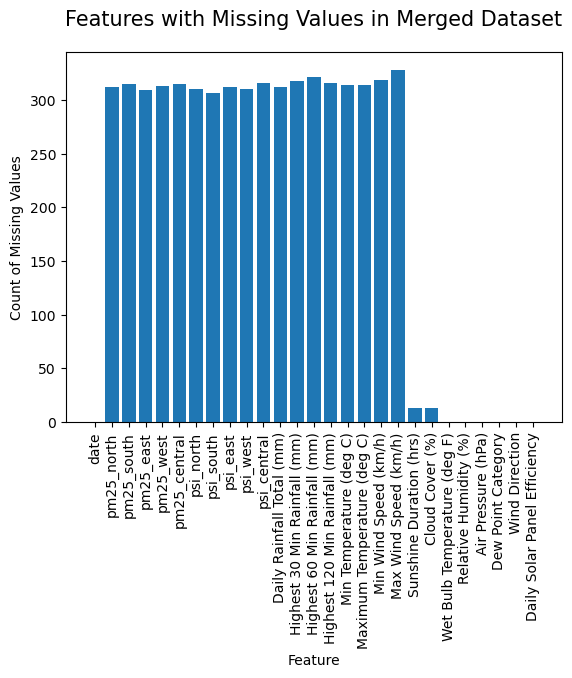

In [196]:
# Identify which features have missing values in the merged dataset.
plt.bar(merged.isnull().sum().index, merged.isnull().sum().values)
plt.xlabel('Feature', fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('Count of Missing Values', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Features with Missing Values in Merged Dataset", fontsize=15, y=1.05)
plt.xticks(rotation=90)
plt.show()

In [197]:
# Fill missing values with the median of each feature.
merged.fillna(merged.select_dtypes('float').median(), inplace=True)

The columns with missing values are identified and filled in with their respective median. Median is used because the distribution
of the features are skewed (as we shall see below). 

### **3. Exploratory Data Analysis**
The purpose of this step are as follow:
1) To understand the features by generating descriptive statistics of each feature.
2) To determine the correlation between the X variables.
3) To explore the relationship (if any) between the X variables and Daily Solar Panel Efficiency (Y variable)

**3.1 Descriptive Statistics**

In [198]:
merged.select_dtypes('float').describe().T

,count,mean,std,min,25%,50%,75%,max
pm25_north,3197.0,14.683922,9.969287,4.0,10.00,13.0,16.00,199.00
pm25_south,3197.0,14.321082,11.381507,3.0,9.00,12.0,16.00,235.00
pm25_east,3197.0,14.193932,10.260374,3.0,10.00,12.0,16.00,176.00
pm25_west,3197.0,13.346419,11.494524,2.0,8.00,11.0,15.00,197.00
pm25_central,3197.0,13.917110,8.795818,3.0,10.00,12.0,16.00,176.00
psi_north,3197.0,51.663278,14.507656,18.0,44.00,52.0,57.00,265.00
psi_south,3197.0,50.610260,15.783663,16.0,42.00,52.0,56.00,288.00
psi_east,3197.0,50.867063,14.403541,17.0,44.00,52.0,56.00,253.00
psi_west,3197.0,48.299969,17.027800,15.0,38.00,49.0,55.00,276.00
psi_central,3197.0,50.266031,13.669382,17.0,43.00,52.0,56.00,238.00


This table shows the mean, standard deviation, 25th, 50th (median), 75th percentiles, min and max values of each numerical features.
These numbers are visualized with the histograms below.

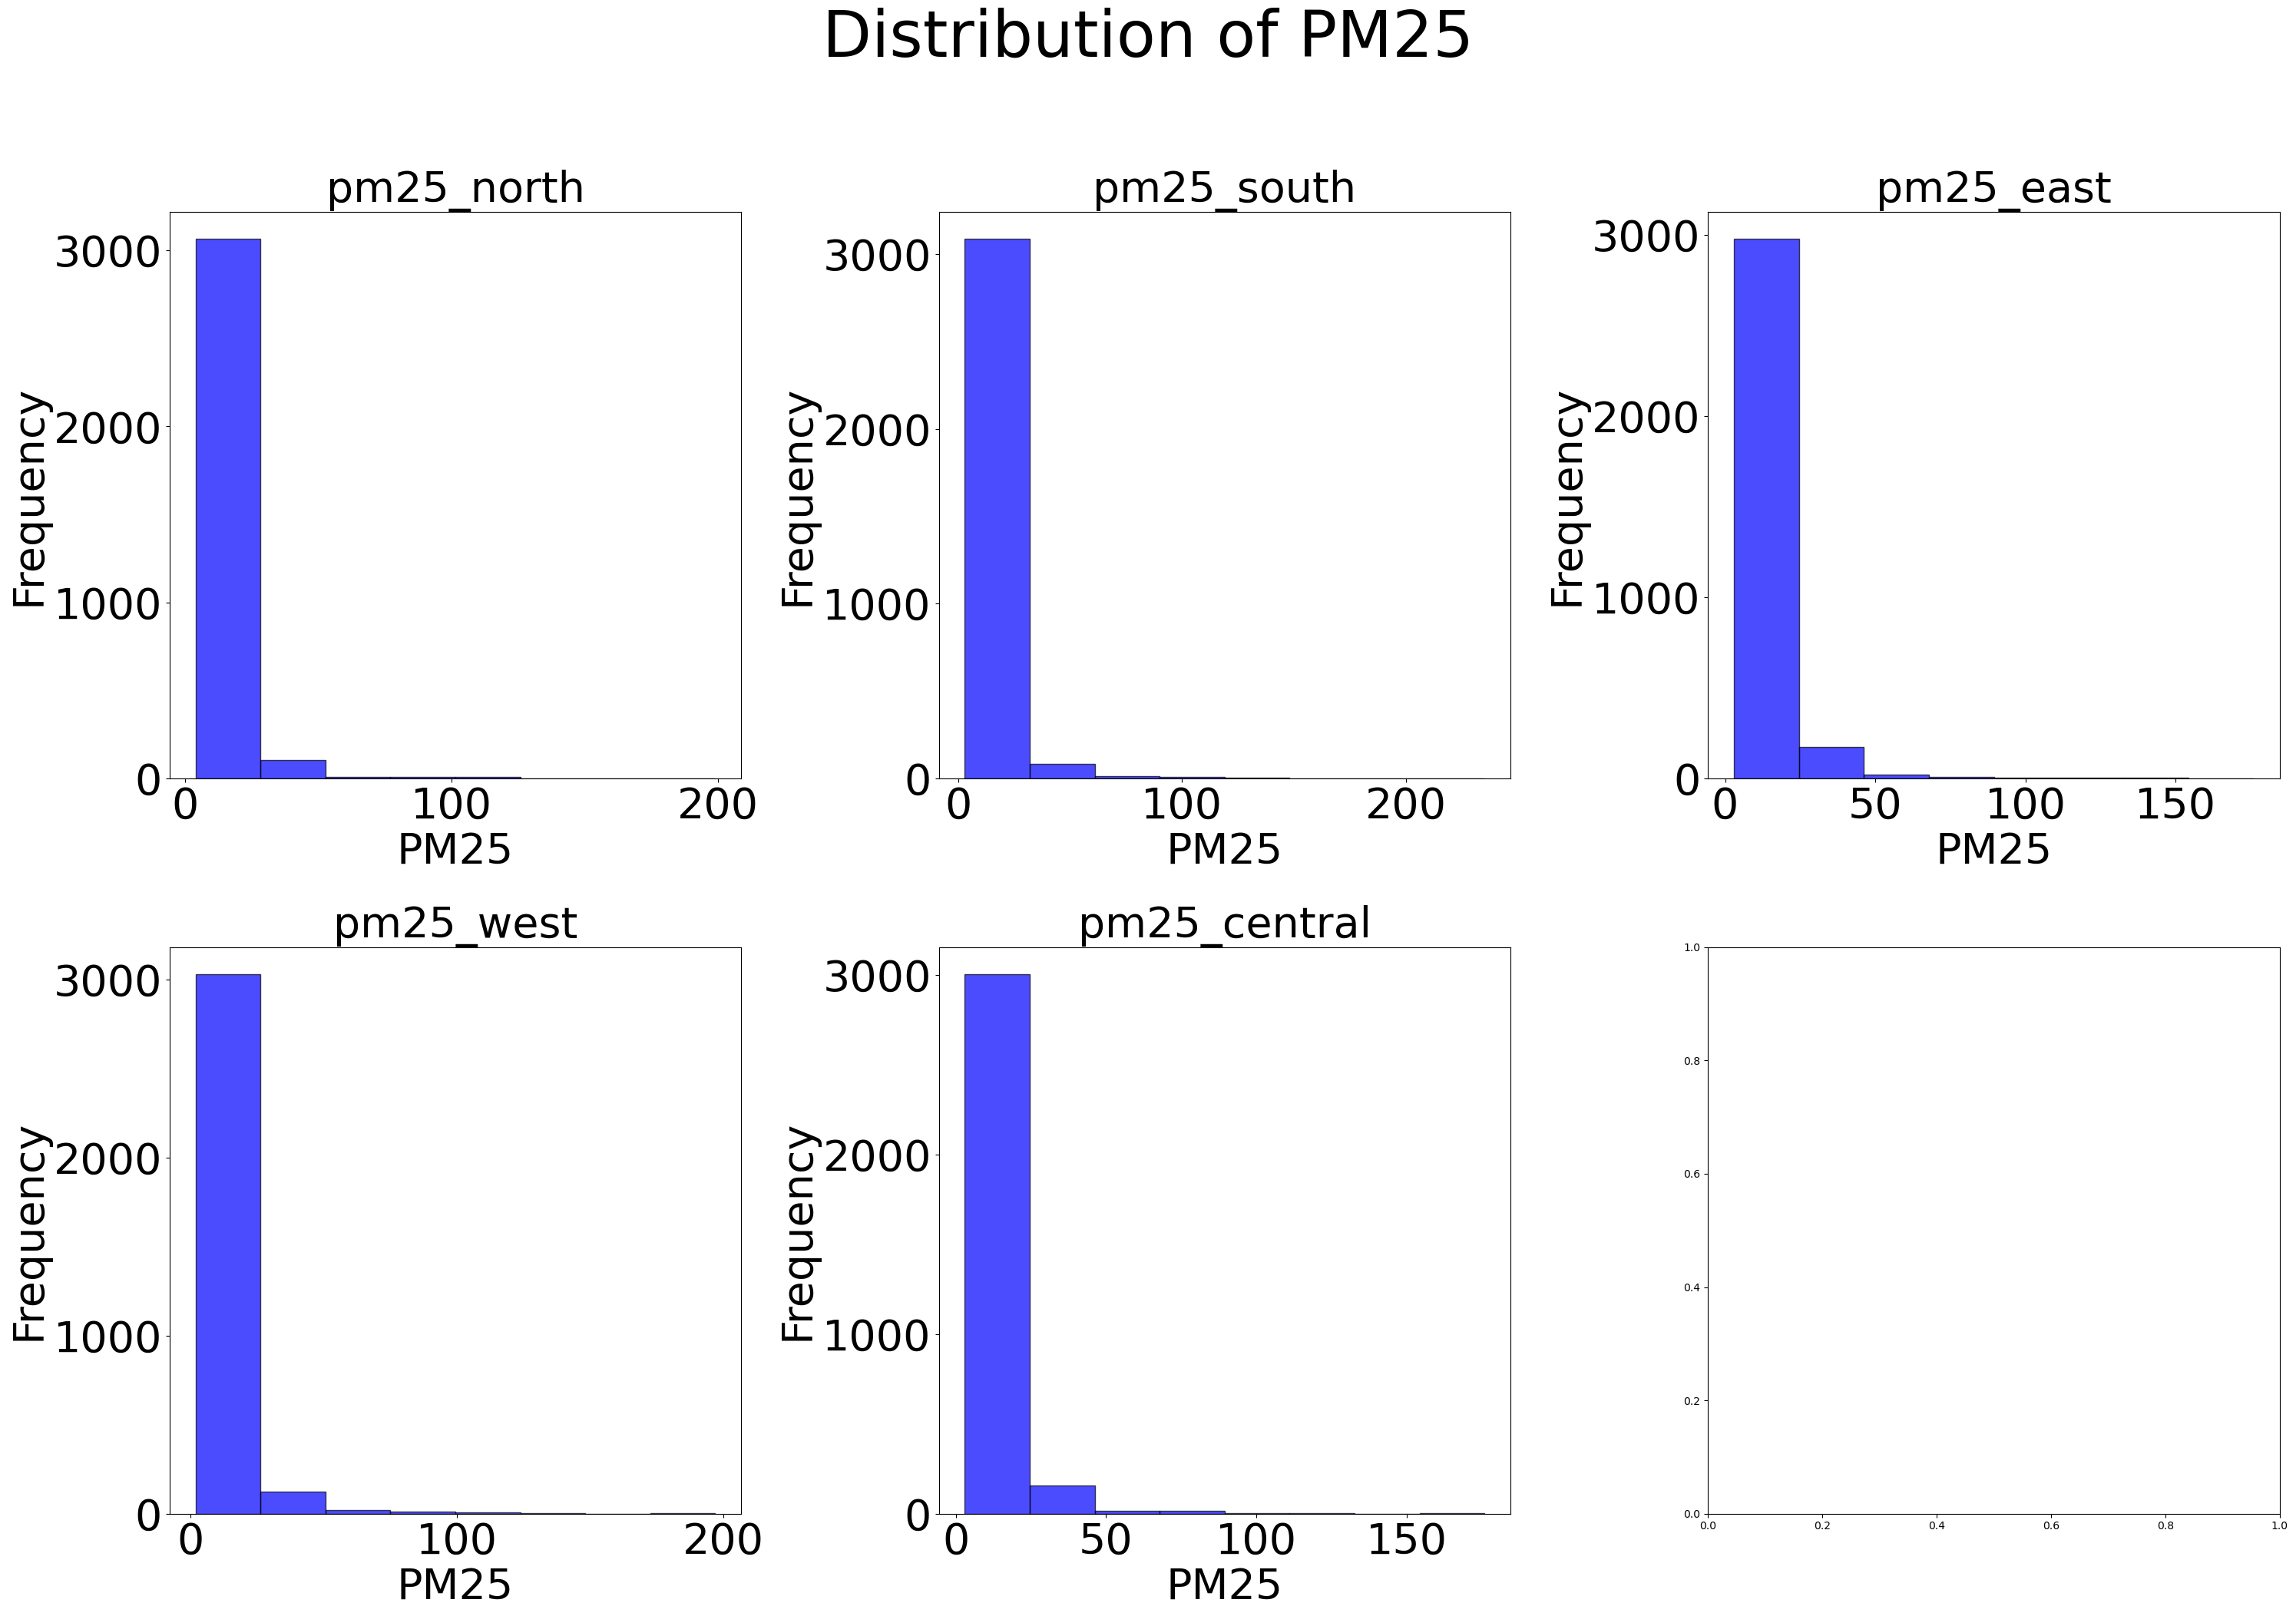

In [199]:
# Distribution of PM25 variables.
fig, ax = plt.subplots(2,3, figsize=(30,20))

r, c = 0, 0

plt.style.use('default')

for f in merged.loc[:, merged.columns.str.contains('pm25')].columns.to_list():
    
    x = merged[f]
    
    ax[r,c].hist(x, bins=8, density=False, color='blue', alpha=0.7, edgecolor='black')
    ax[r,c].set_ylabel('Frequency', fontdict={'fontsize':40})
    ax[r,c].set_xlabel('PM25', fontdict={'fontsize':40})
    ax[r,c].tick_params(axis='both', labelsize=40)
    ax[r,c].set_title(f, fontdict={'fontsize':40})
    
    if c>1:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Distribution of PM25', fontsize=60, y=1.05)    
fig.tight_layout(h_pad=3)
plt.show()

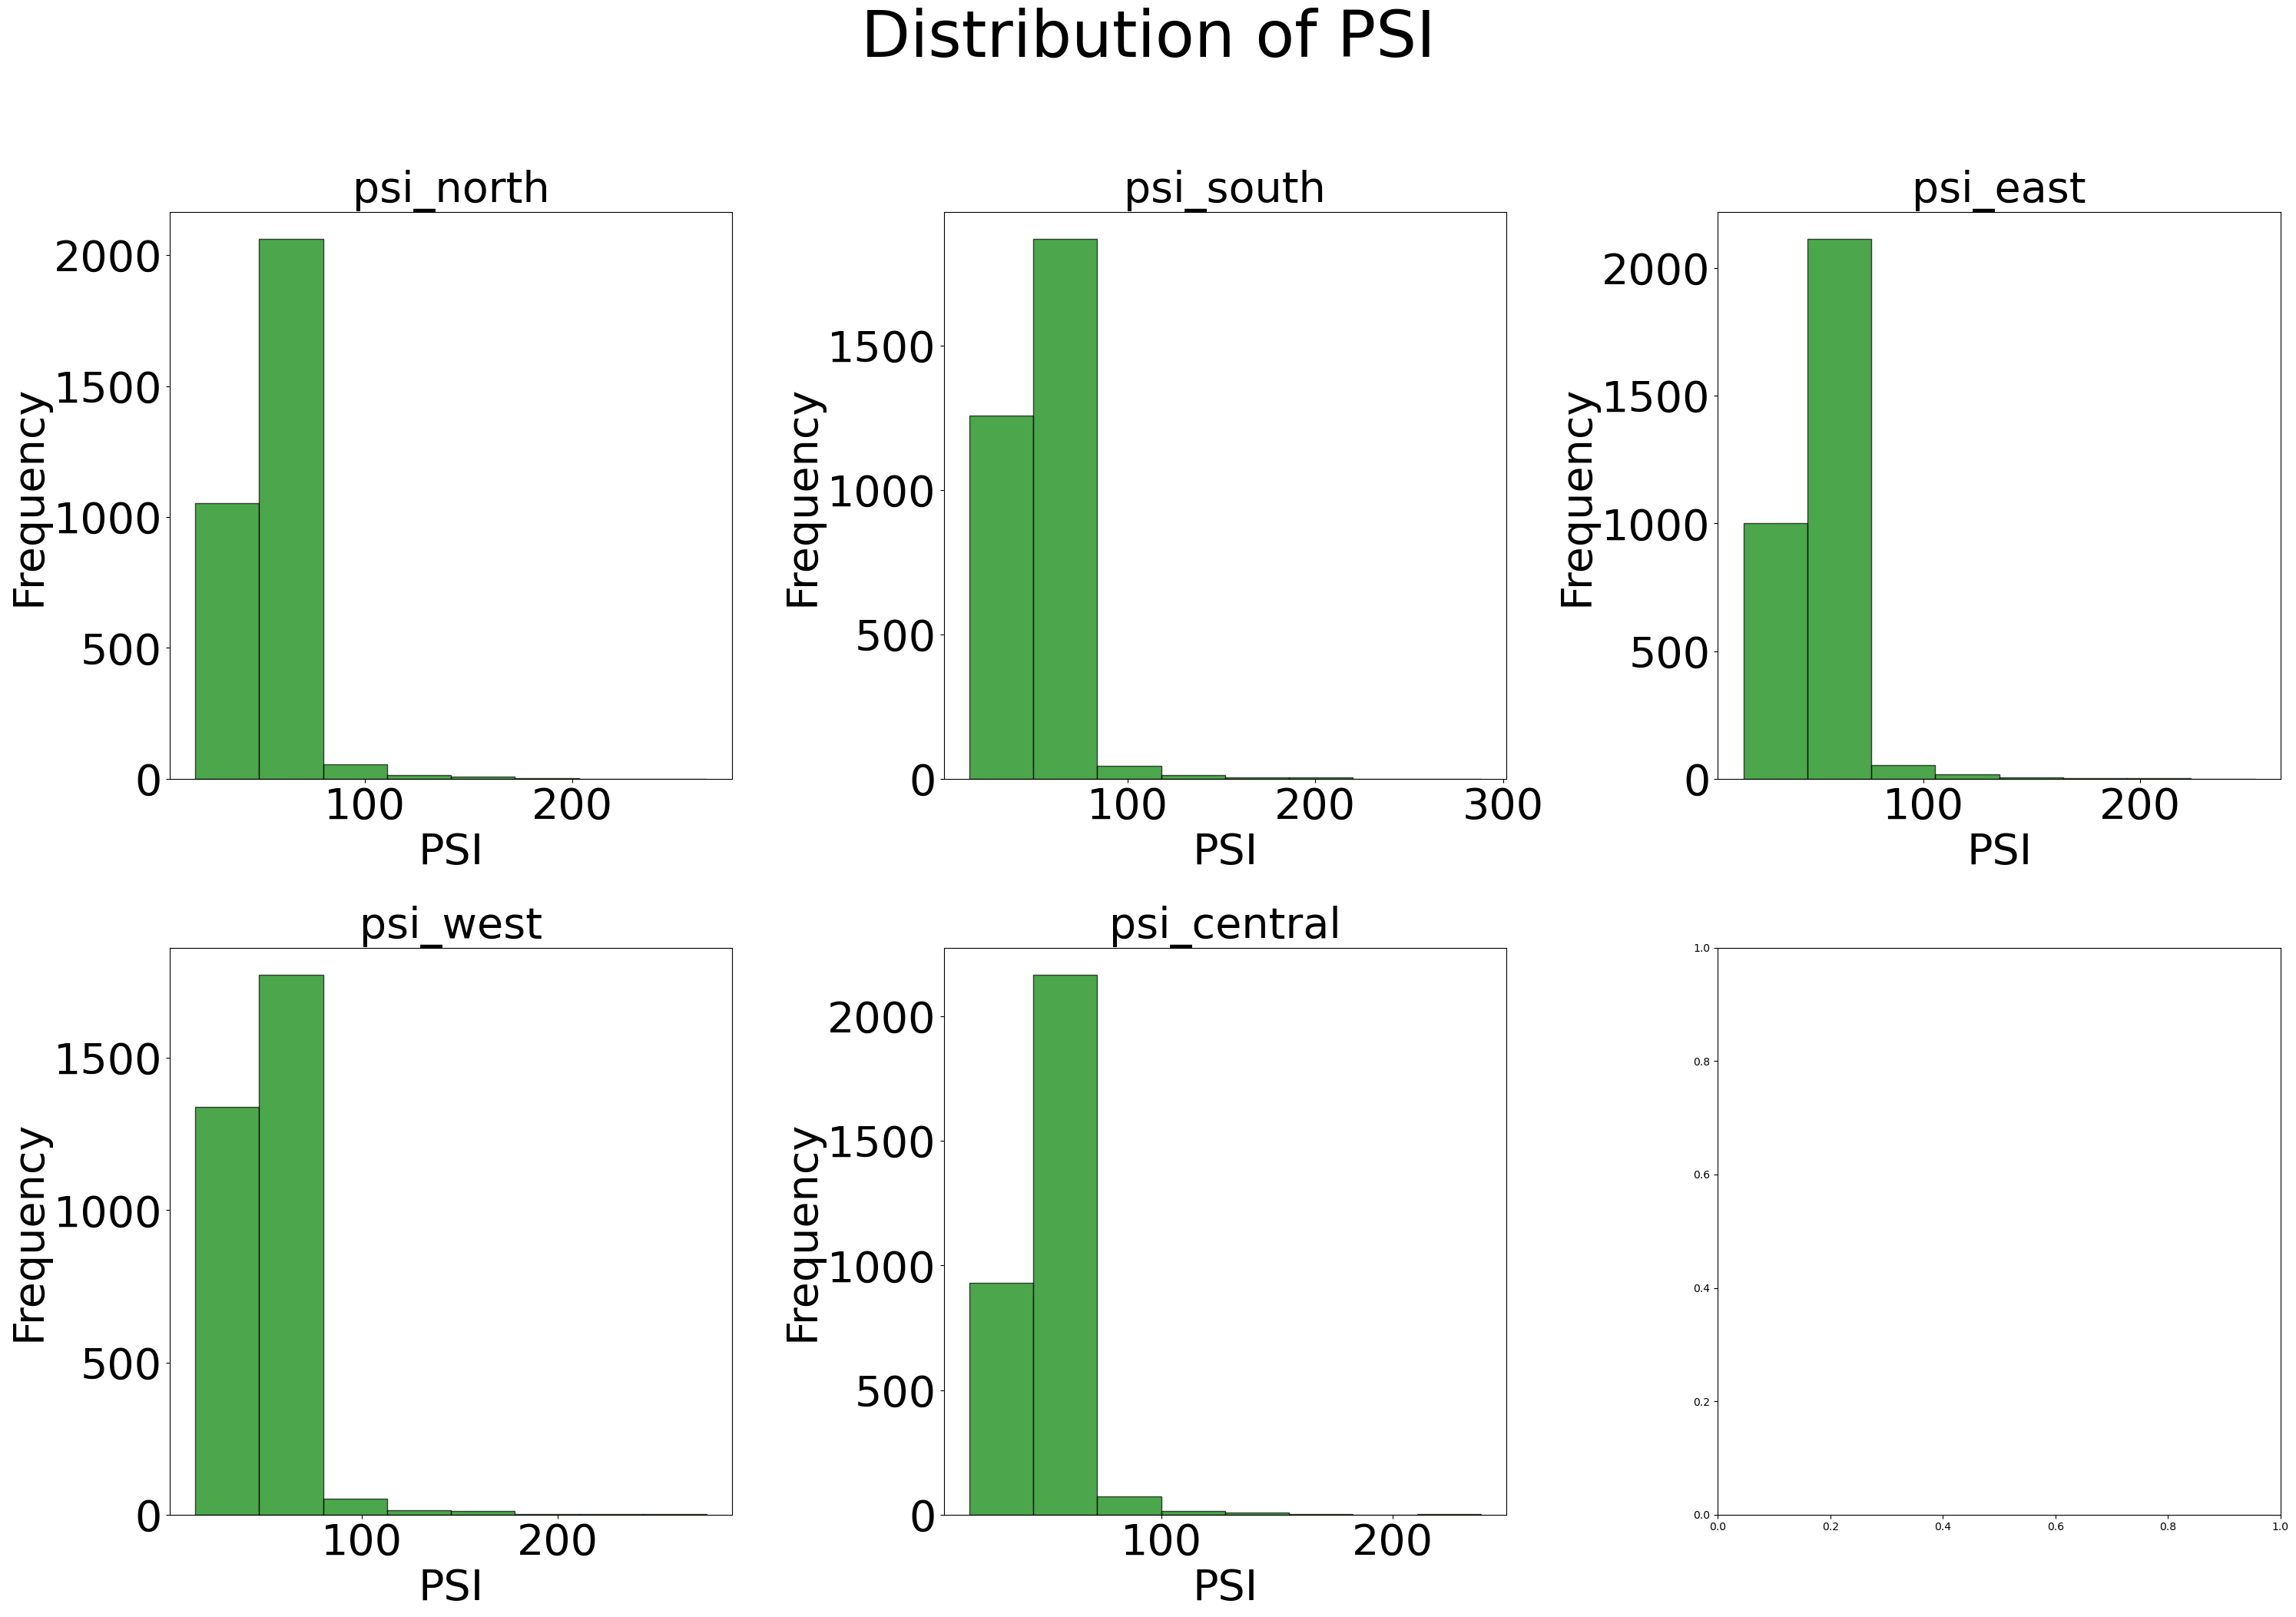

In [200]:
# Distribution of PSI variables.
fig, ax = plt.subplots(2,3, figsize=(30,20))

r, c = 0, 0

plt.style.use('default')

for f in merged.loc[:, merged.columns.str.contains('psi')].columns.to_list():
    
    x = merged[f]
    
    ax[r,c].hist(x, bins=8, density=False, color='green', alpha=0.7, edgecolor='black')
    ax[r,c].set_ylabel('Frequency', fontdict={'fontsize':40})
    ax[r,c].set_xlabel('PSI', fontdict={'fontsize':40})
    ax[r,c].tick_params(axis='both', labelsize=40)
    ax[r,c].set_title(f, fontdict={'fontsize':40})
    
    if c>1:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Distribution of PSI', fontsize=60, y=1.05)    
fig.tight_layout(h_pad=3)
plt.show()

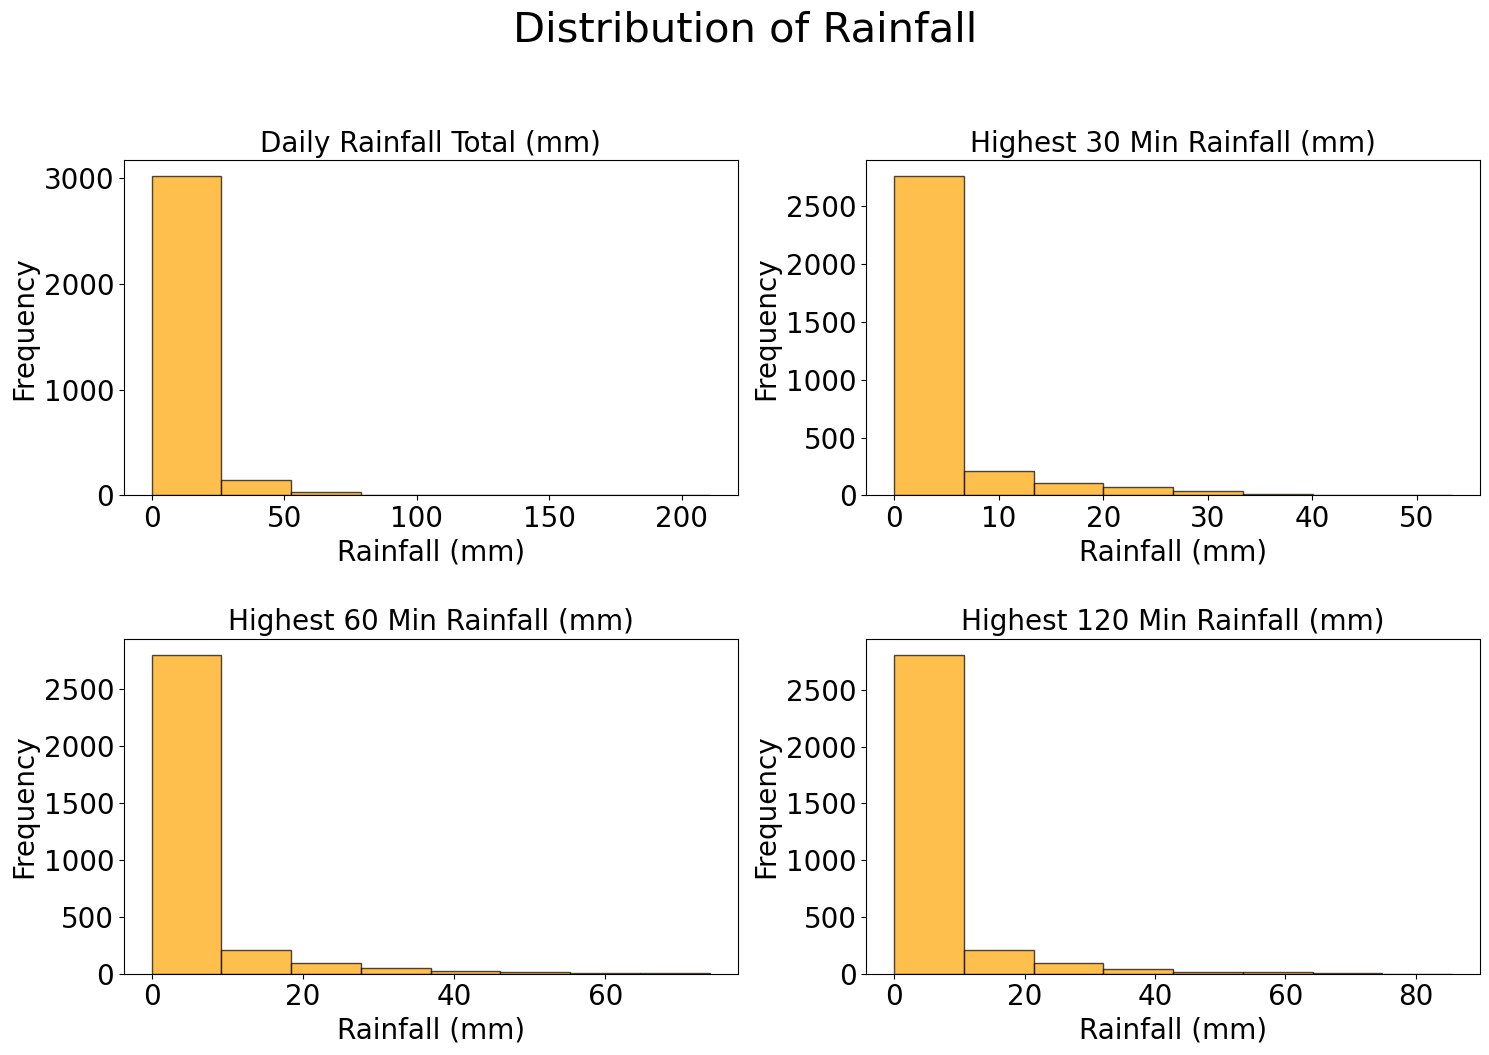

In [201]:
# Distribution of Rainfall variables.
fig, ax = plt.subplots(2,2, figsize=(15,10))

r, c = 0, 0

plt.style.use('default')

for f in merged.loc[:, merged.columns.str.contains('Rainfall')].columns.to_list():
    
    x = merged[f]
    
    ax[r,c].hist(x, bins=8, density=False, color='orange', alpha=0.7, edgecolor='black')
    ax[r,c].set_ylabel('Frequency', fontdict={'fontsize':20})
    ax[r,c].set_xlabel('Rainfall (mm)', fontdict={'fontsize':20})
    ax[r,c].tick_params(axis='both', labelsize=20)
    ax[r,c].set_title(f, fontdict={'fontsize':20})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Distribution of Rainfall', fontsize=30, y=1.05)    
fig.tight_layout(h_pad=3)
plt.show()

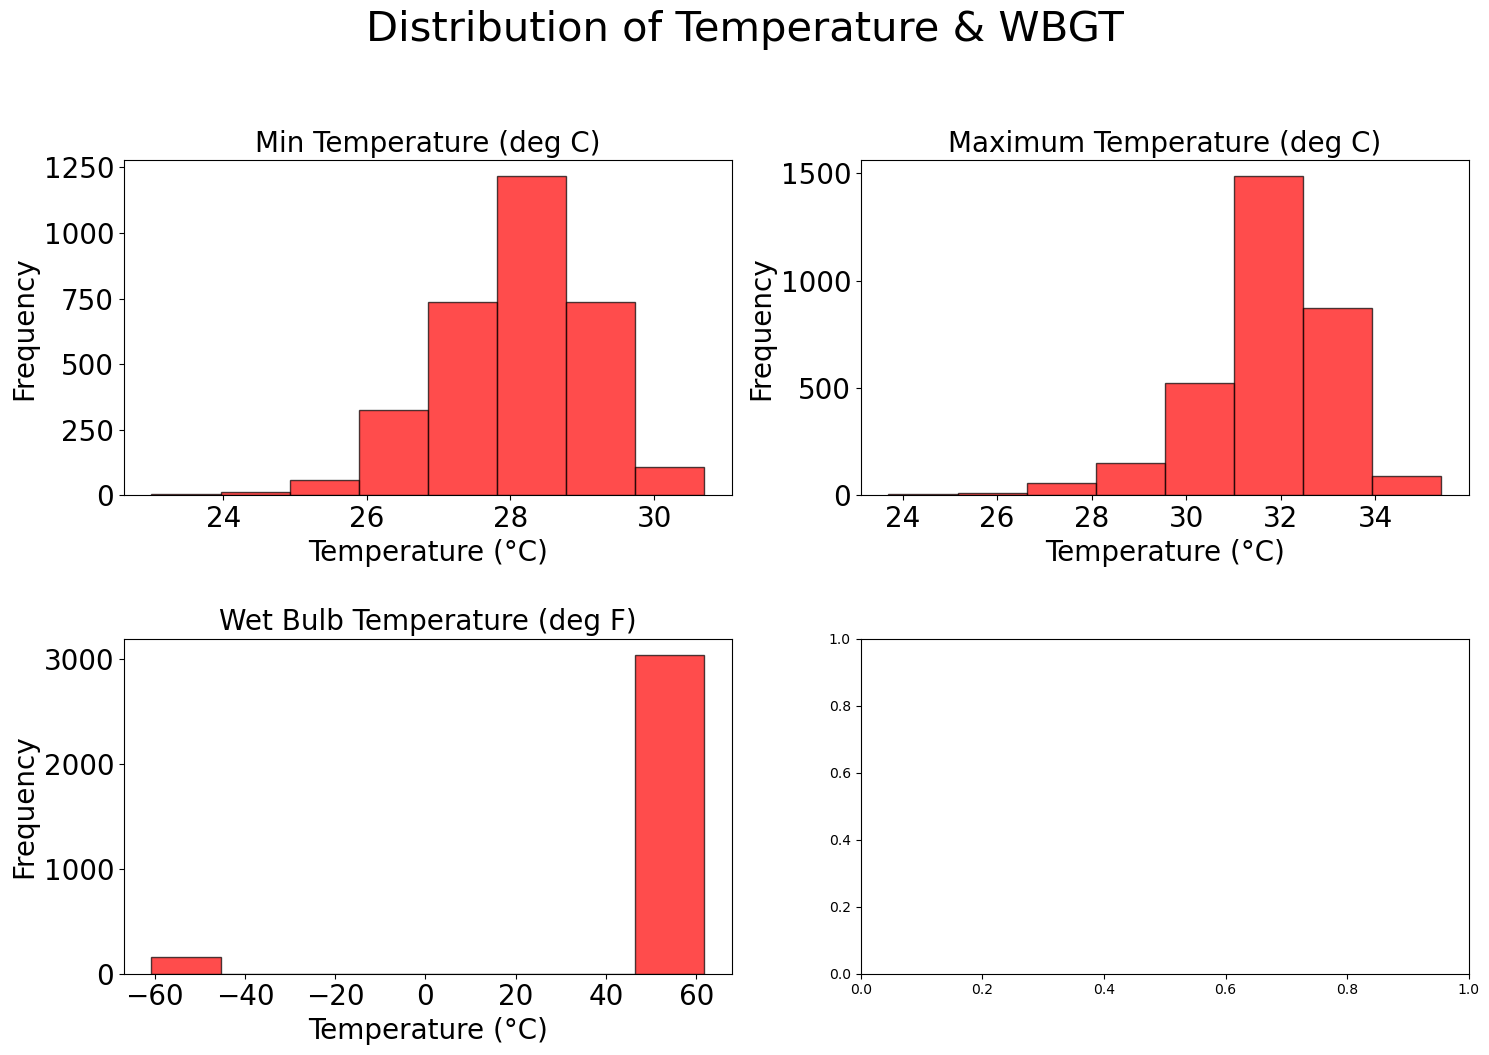

In [202]:
# Distribution of Temperature and WBGT variables.

fig, ax = plt.subplots(2,2, figsize=(15,10))

r, c = 0, 0

plt.style.use('default')

for f in merged.loc[:, merged.columns.str.contains('Temperature')].columns.to_list():
    
    x = merged[f]
    
    ax[r,c].hist(x, bins=8, density=False, color='red', alpha=0.7, edgecolor='black')
    ax[r,c].set_ylabel('Frequency', fontdict={'fontsize':20})
    ax[r,c].set_xlabel('Temperature (°C)', fontdict={'fontsize':20})
    ax[r,c].tick_params(axis='both', labelsize=20)
    ax[r,c].set_title(f, fontdict={'fontsize':20})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Distribution of Temperature & WBGT', fontsize=30, y=1.05)    
fig.tight_layout(h_pad=3)
plt.show()

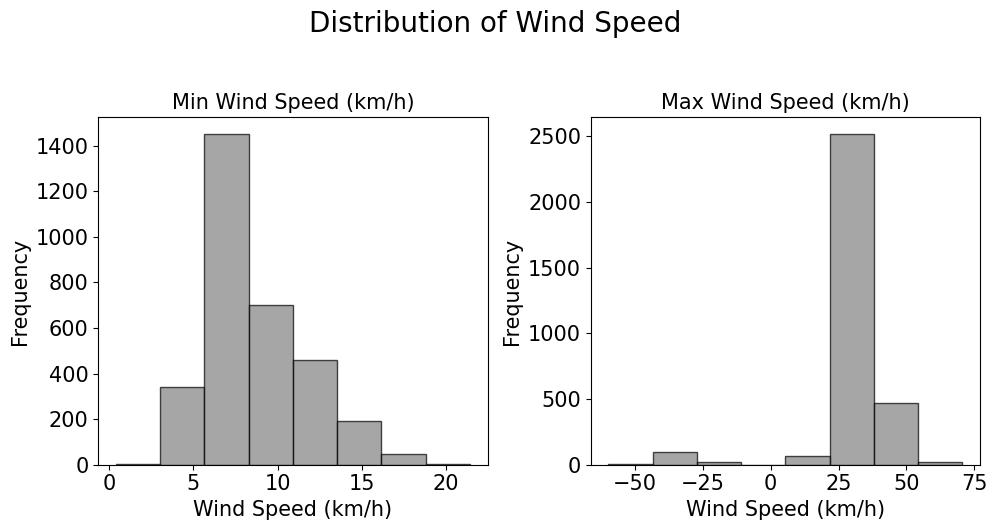

In [203]:
# Distribution of Wind Speed variables.
fig, ax = plt.subplots(1,2, figsize=(10,5))

r, c = 0, 0

plt.style.use('default')

for f in merged.loc[:, merged.columns.str.contains('Wind Speed')].columns.to_list():
    
    x = merged[f]
    
    ax[c].hist(x, bins=8, density=False, color='grey', alpha=0.7, edgecolor='black')
    ax[c].set_ylabel('Frequency', fontdict={'fontsize':15})
    ax[c].set_xlabel('Wind Speed (km/h)', fontdict={'fontsize':15})
    ax[c].tick_params(axis='both', labelsize=15)
    ax[c].set_title(f, fontdict={'fontsize':15})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Distribution of Wind Speed', fontsize=20, y=1.05)    
fig.tight_layout(h_pad=3)
plt.show()

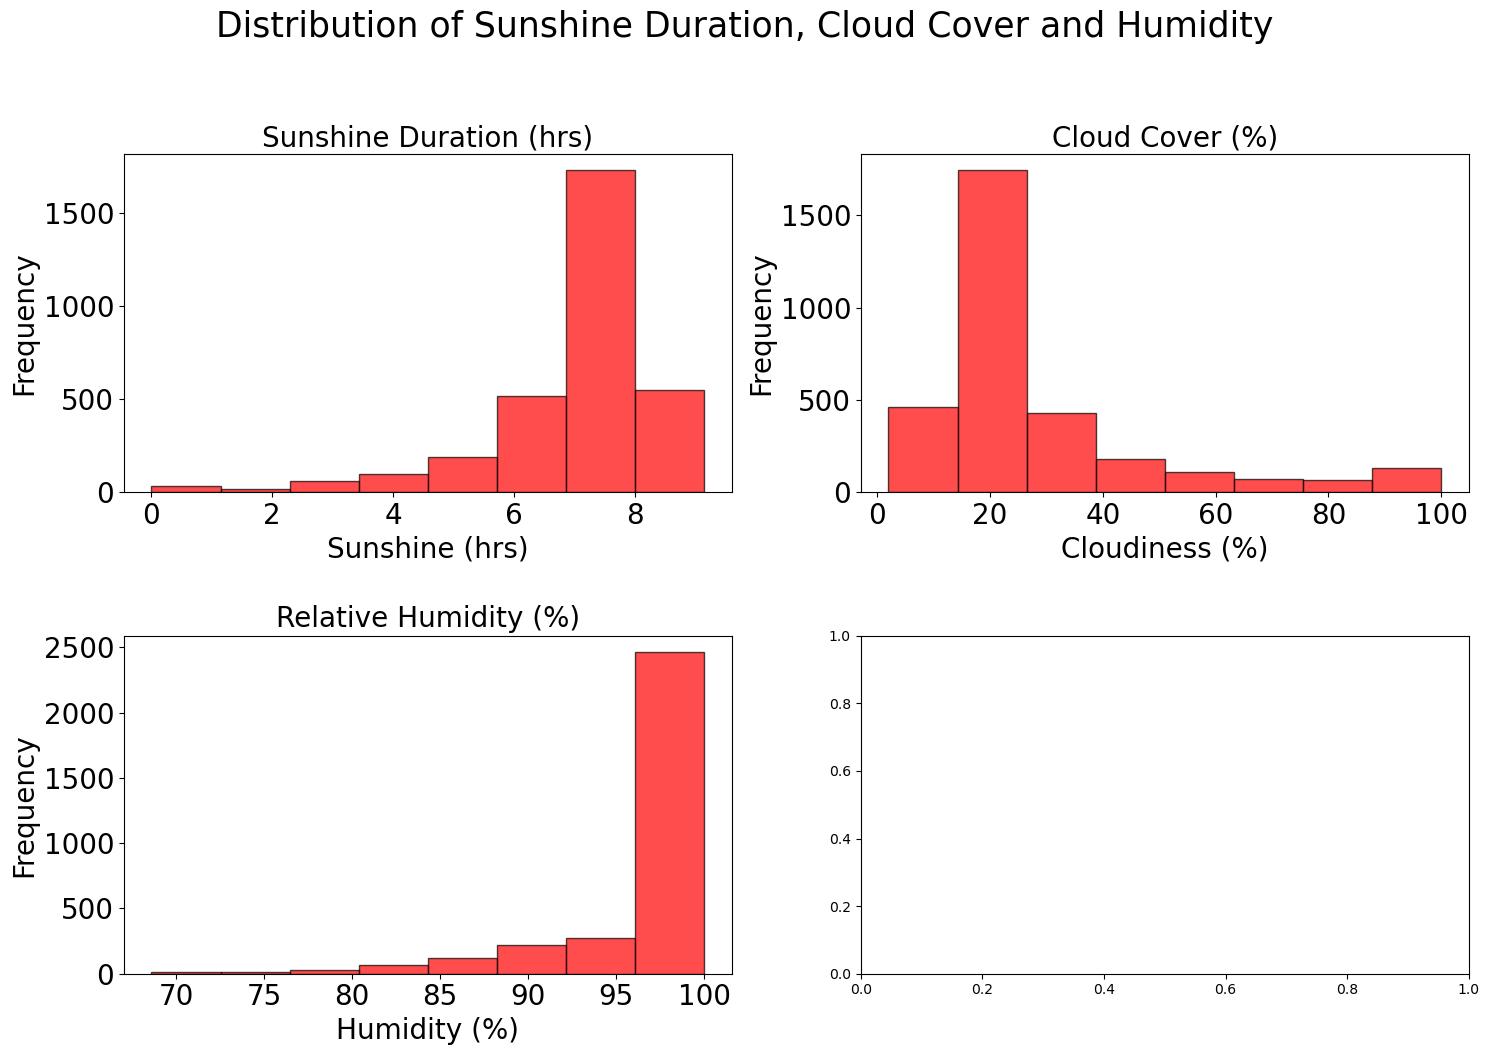

In [204]:
# Distribution of Sunshine, Cloud Cover and Humidity variables.
fig, ax = plt.subplots(2,2, figsize=(15,10))

r, c , i = 0, 0, 0

xlabel = ['Sunshine (hrs)','Cloudiness (%)','Humidity (%)']

plt.style.use('default')

for f in merged.loc[:, merged.columns.str.contains('Cloud|Sunshine|Humidity')].columns.to_list():
    
    x = merged[f]
    
    ax[r,c].hist(x, bins=8, density=False, color='red', alpha=0.7, edgecolor='black')
    ax[r,c].set_ylabel('Frequency', fontdict={'fontsize':20})
    ax[r,c].set_xlabel(xlabel[i], fontdict={'fontsize':20})
    ax[r,c].tick_params(axis='both', labelsize=20)
    ax[r,c].set_title(f, fontdict={'fontsize':20})
    i+=1
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Distribution of Sunshine Duration, Cloud Cover and Humidity', fontsize=25, y=1.05)    
fig.tight_layout(h_pad=3)
plt.show()

As can be observed from the histogram, most of the features are either right-skewed or left-skewed, indicating that they are not
normally distributed and have outliers on either side of their distributions. However, this is not a concern because the algorithms used
for prediction are not affected distributional shape and are robust to the presence of outliers. 

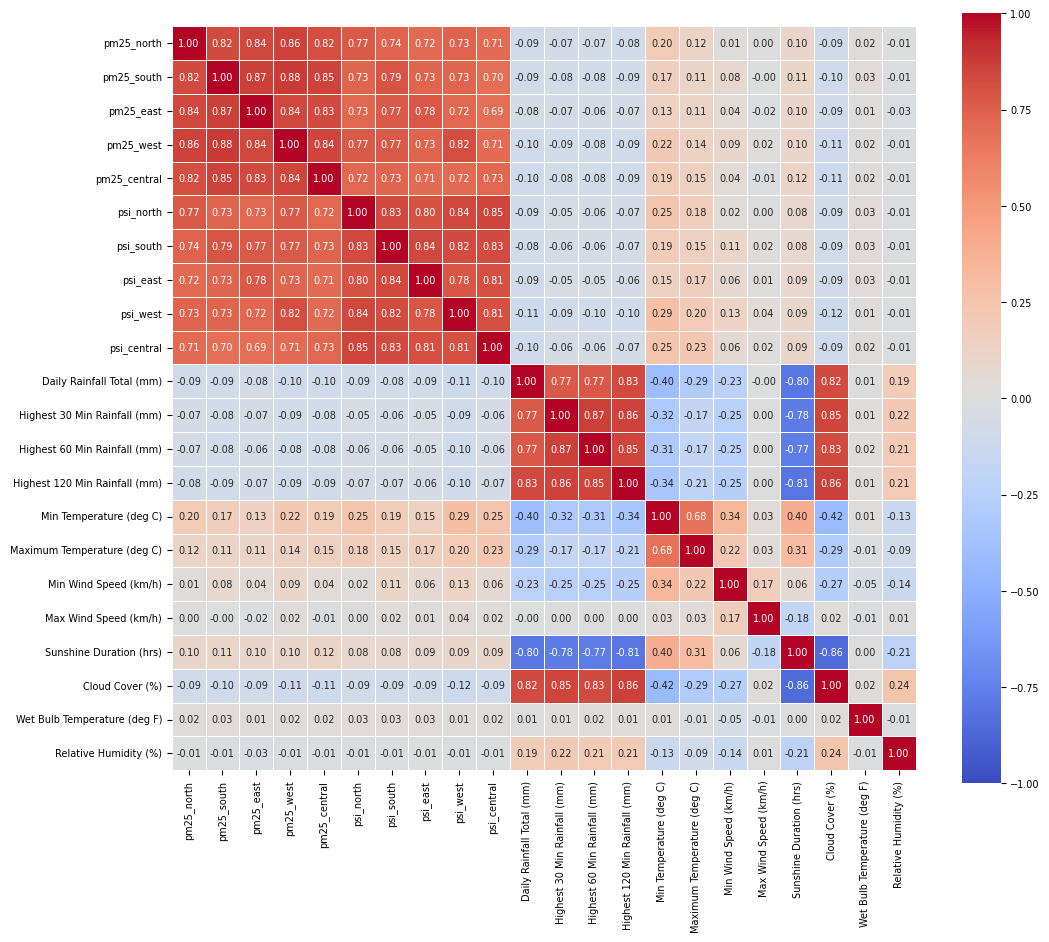

In [205]:
# Determine the correlation between the numerical X variables.
correlation = merged.select_dtypes('float').corr()
plt.figure(figsize = (12,10))
plt.rcParams.update({'font.size': 7})
sns.heatmap(correlation, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.show()

The heatmap above shows that several features are correlated among each other. PM25 and PSI variables are highly correlated.
The temperature-related variables are also highly correlated. The rainfall-related variables are correlated with each other.
Sunshine and cloud cover are highly correlated with each other and with the rainfall-related variables. The patterns suggest
that some of these variables can be dropped to prevent collinearity, as they may be redundant and add little value to the
prediction performance.

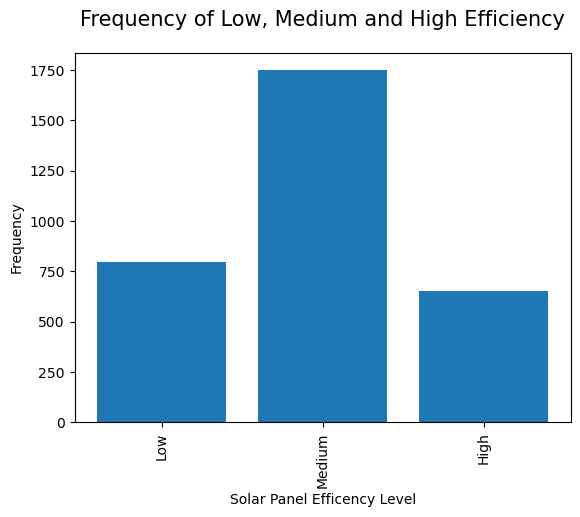

In [206]:
# Check the counts of Low, Medium and High classes of Daily Solar Panel Efficiency (Y).
efficiency_class = merged['Daily Solar Panel Efficiency'].value_counts(normalize=False)[['Low','Medium','High']]
plt.bar(efficiency_class.index, efficiency_class.values)
plt.xlabel('Solar Panel Efficency Level', fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Frequency of Low, Medium and High Efficiency", fontsize=15, y=1.05)
plt.xticks(rotation=90)
plt.show()

The barchart shows the count of each of the 3 levels (classes) of Daily Solar Panel Efficiency variable (Y).
The 3 classes are not balanced, indicating that it is an imbalanced dataset with regard to the Y variable.
This information should be taken into account when training model to predict the 3 classes, as there are less instances
from the underrepresented classes for the algorithm to learn during training. This suggest that techniques (e.g weighting or SMOTE) for dealing
with imabalanced dataset need to be applied. An approprate evalution metric (e.g balanced accuracy) must also be selected to assess the
performance of our model.


**3.2 Relationship between Daily Solar Panel Efficiency(Y) and numerical features(X).**

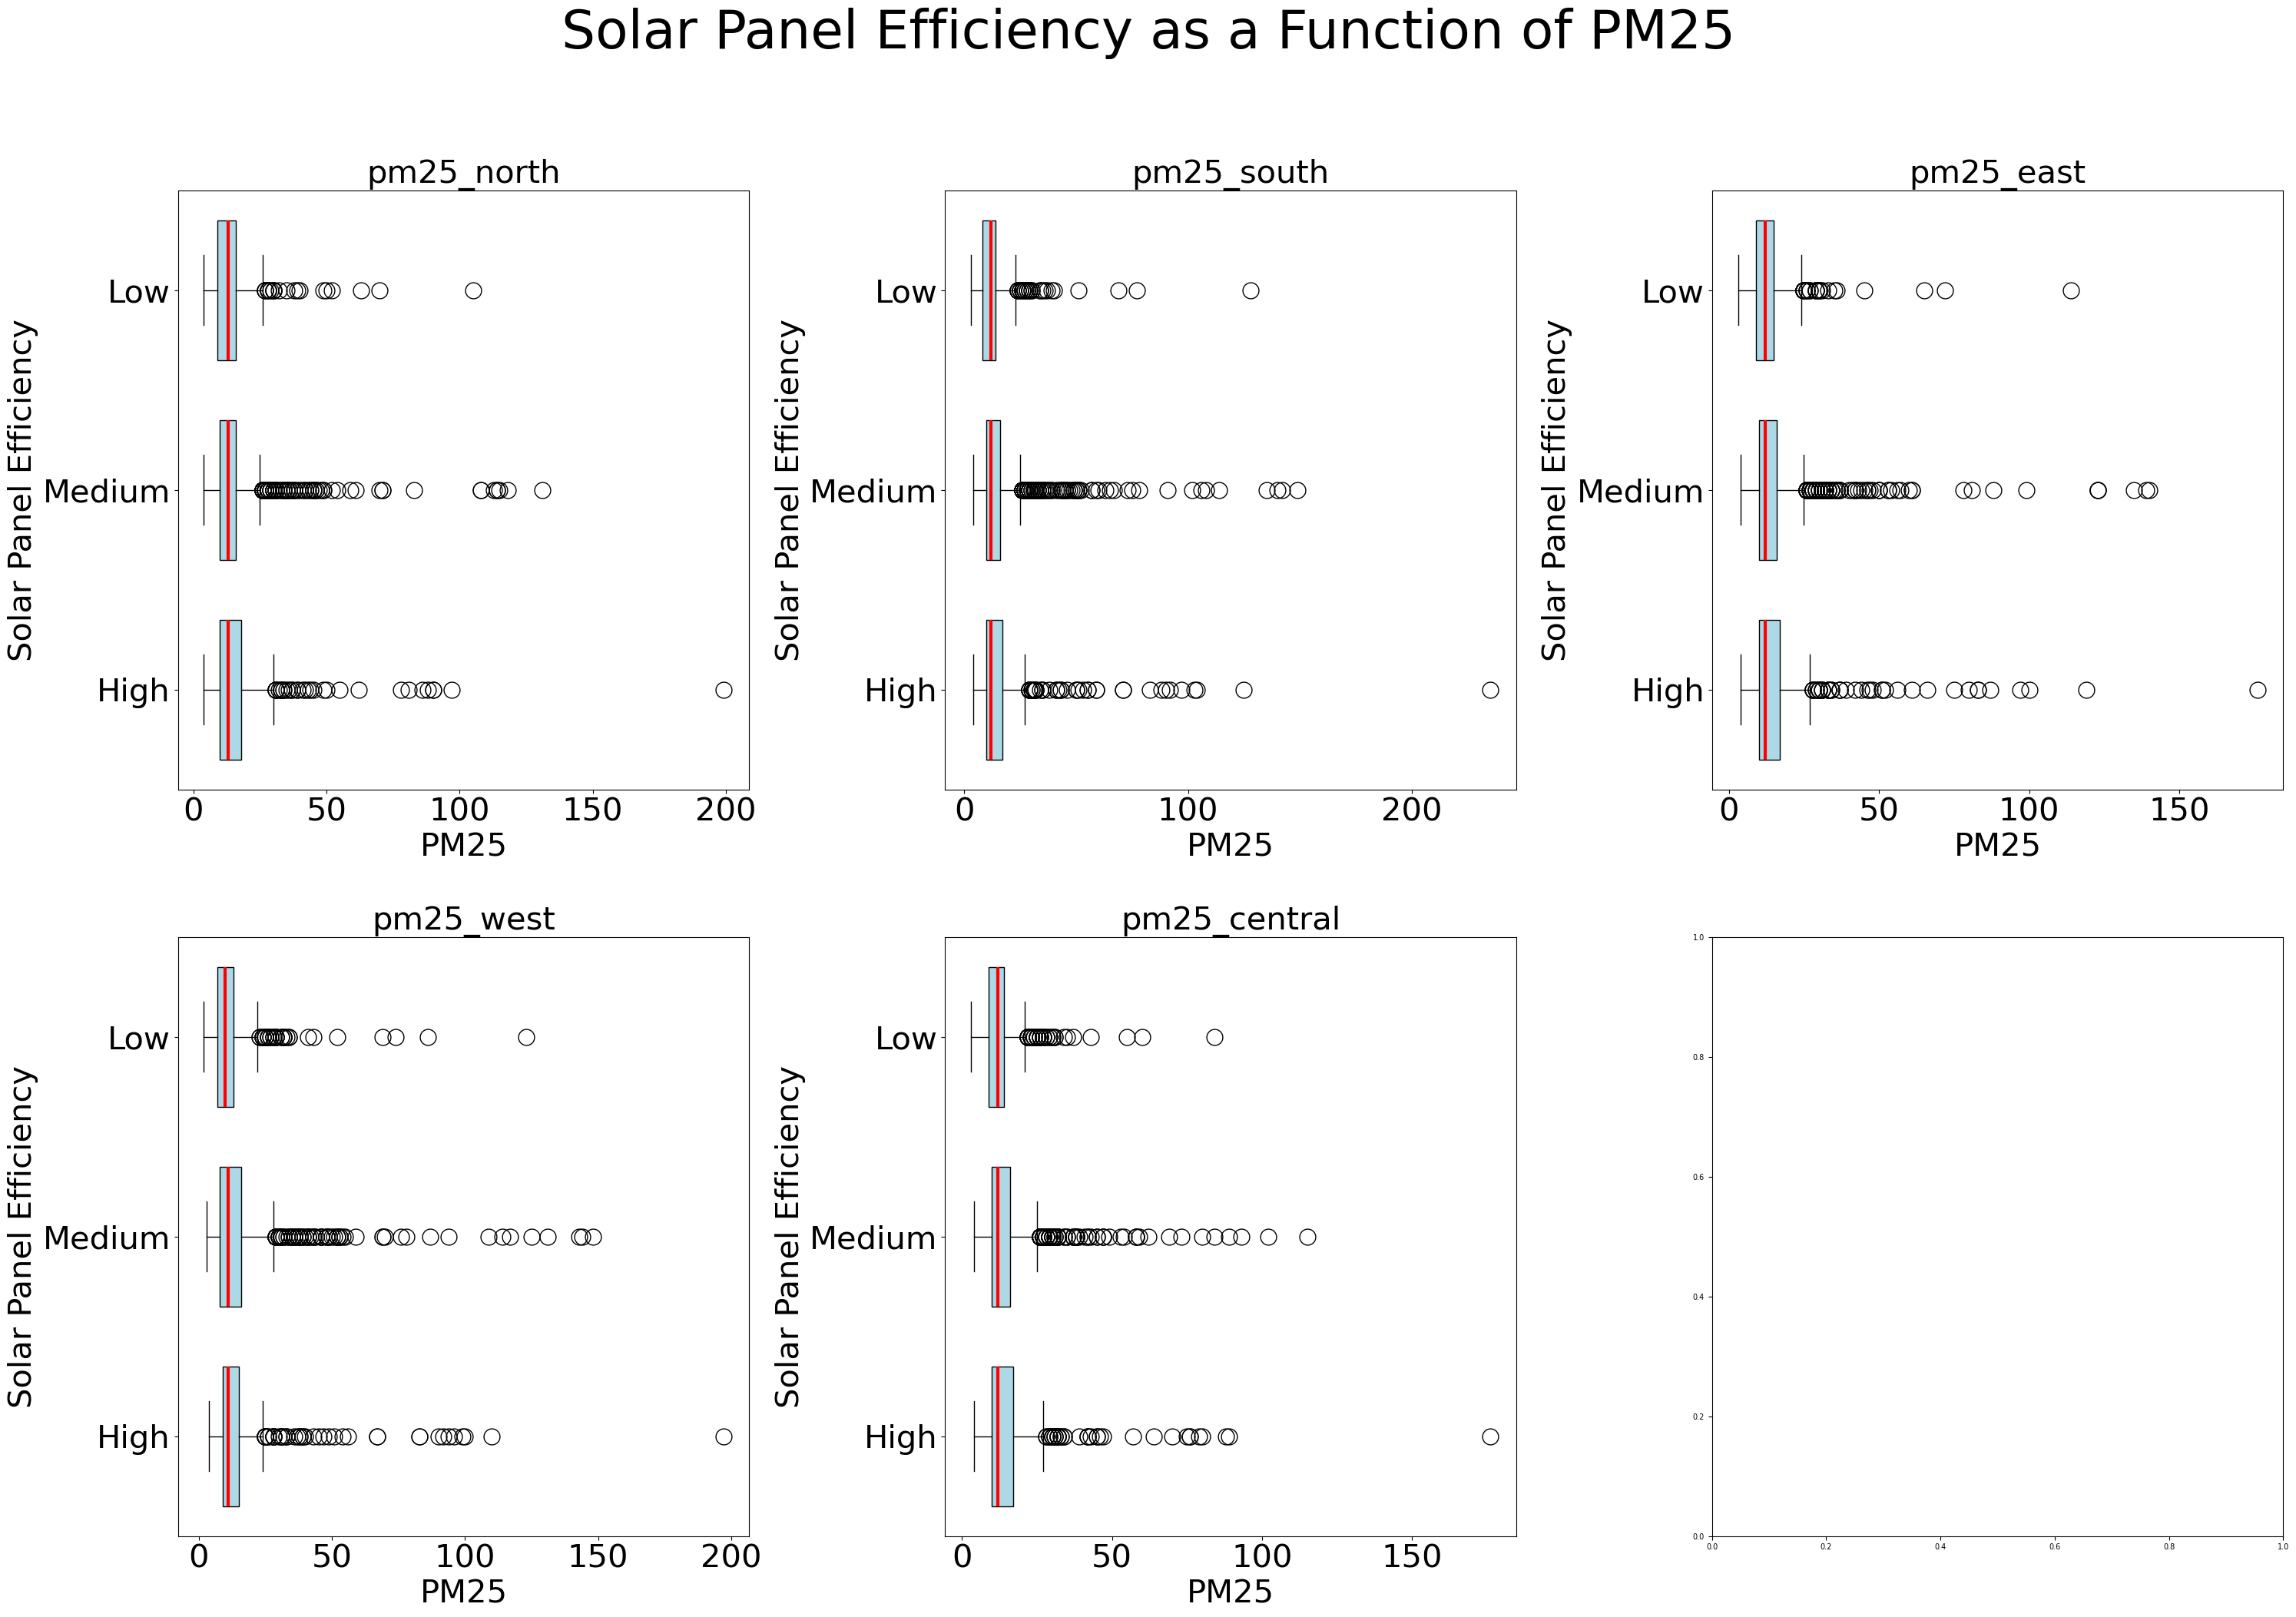

In [207]:
# Visualizing the relationship between Daily Solar Panel Efficiency(Y) and pm25 features(X).
fig, ax = plt.subplots(2,3, figsize=(30,20))

r, c = 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('pm25')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':3, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 15}, vert=False)
    ax[r,c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':30})
    ax[r,c].set_yticklabels(labels, fontsize=30)
    ax[r,c].set_xlabel('PM25', fontdict={'fontsize':30})
    ax[r,c].tick_params(axis='x', labelsize=30)
    ax[r,c].set_title(f, fontdict={'fontsize':30})
    
    if c>1:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of PM25', fontsize=50, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

No relationship is observed. The different levels (classes) of Daily Solar Panel Efficiency are not differentially distributed
across the PM25 of any direction. This suggests that knowinng the PM25 numbers provide little information on the likeihood of
whether the solar panel efficiency on that day is low, medium or high.

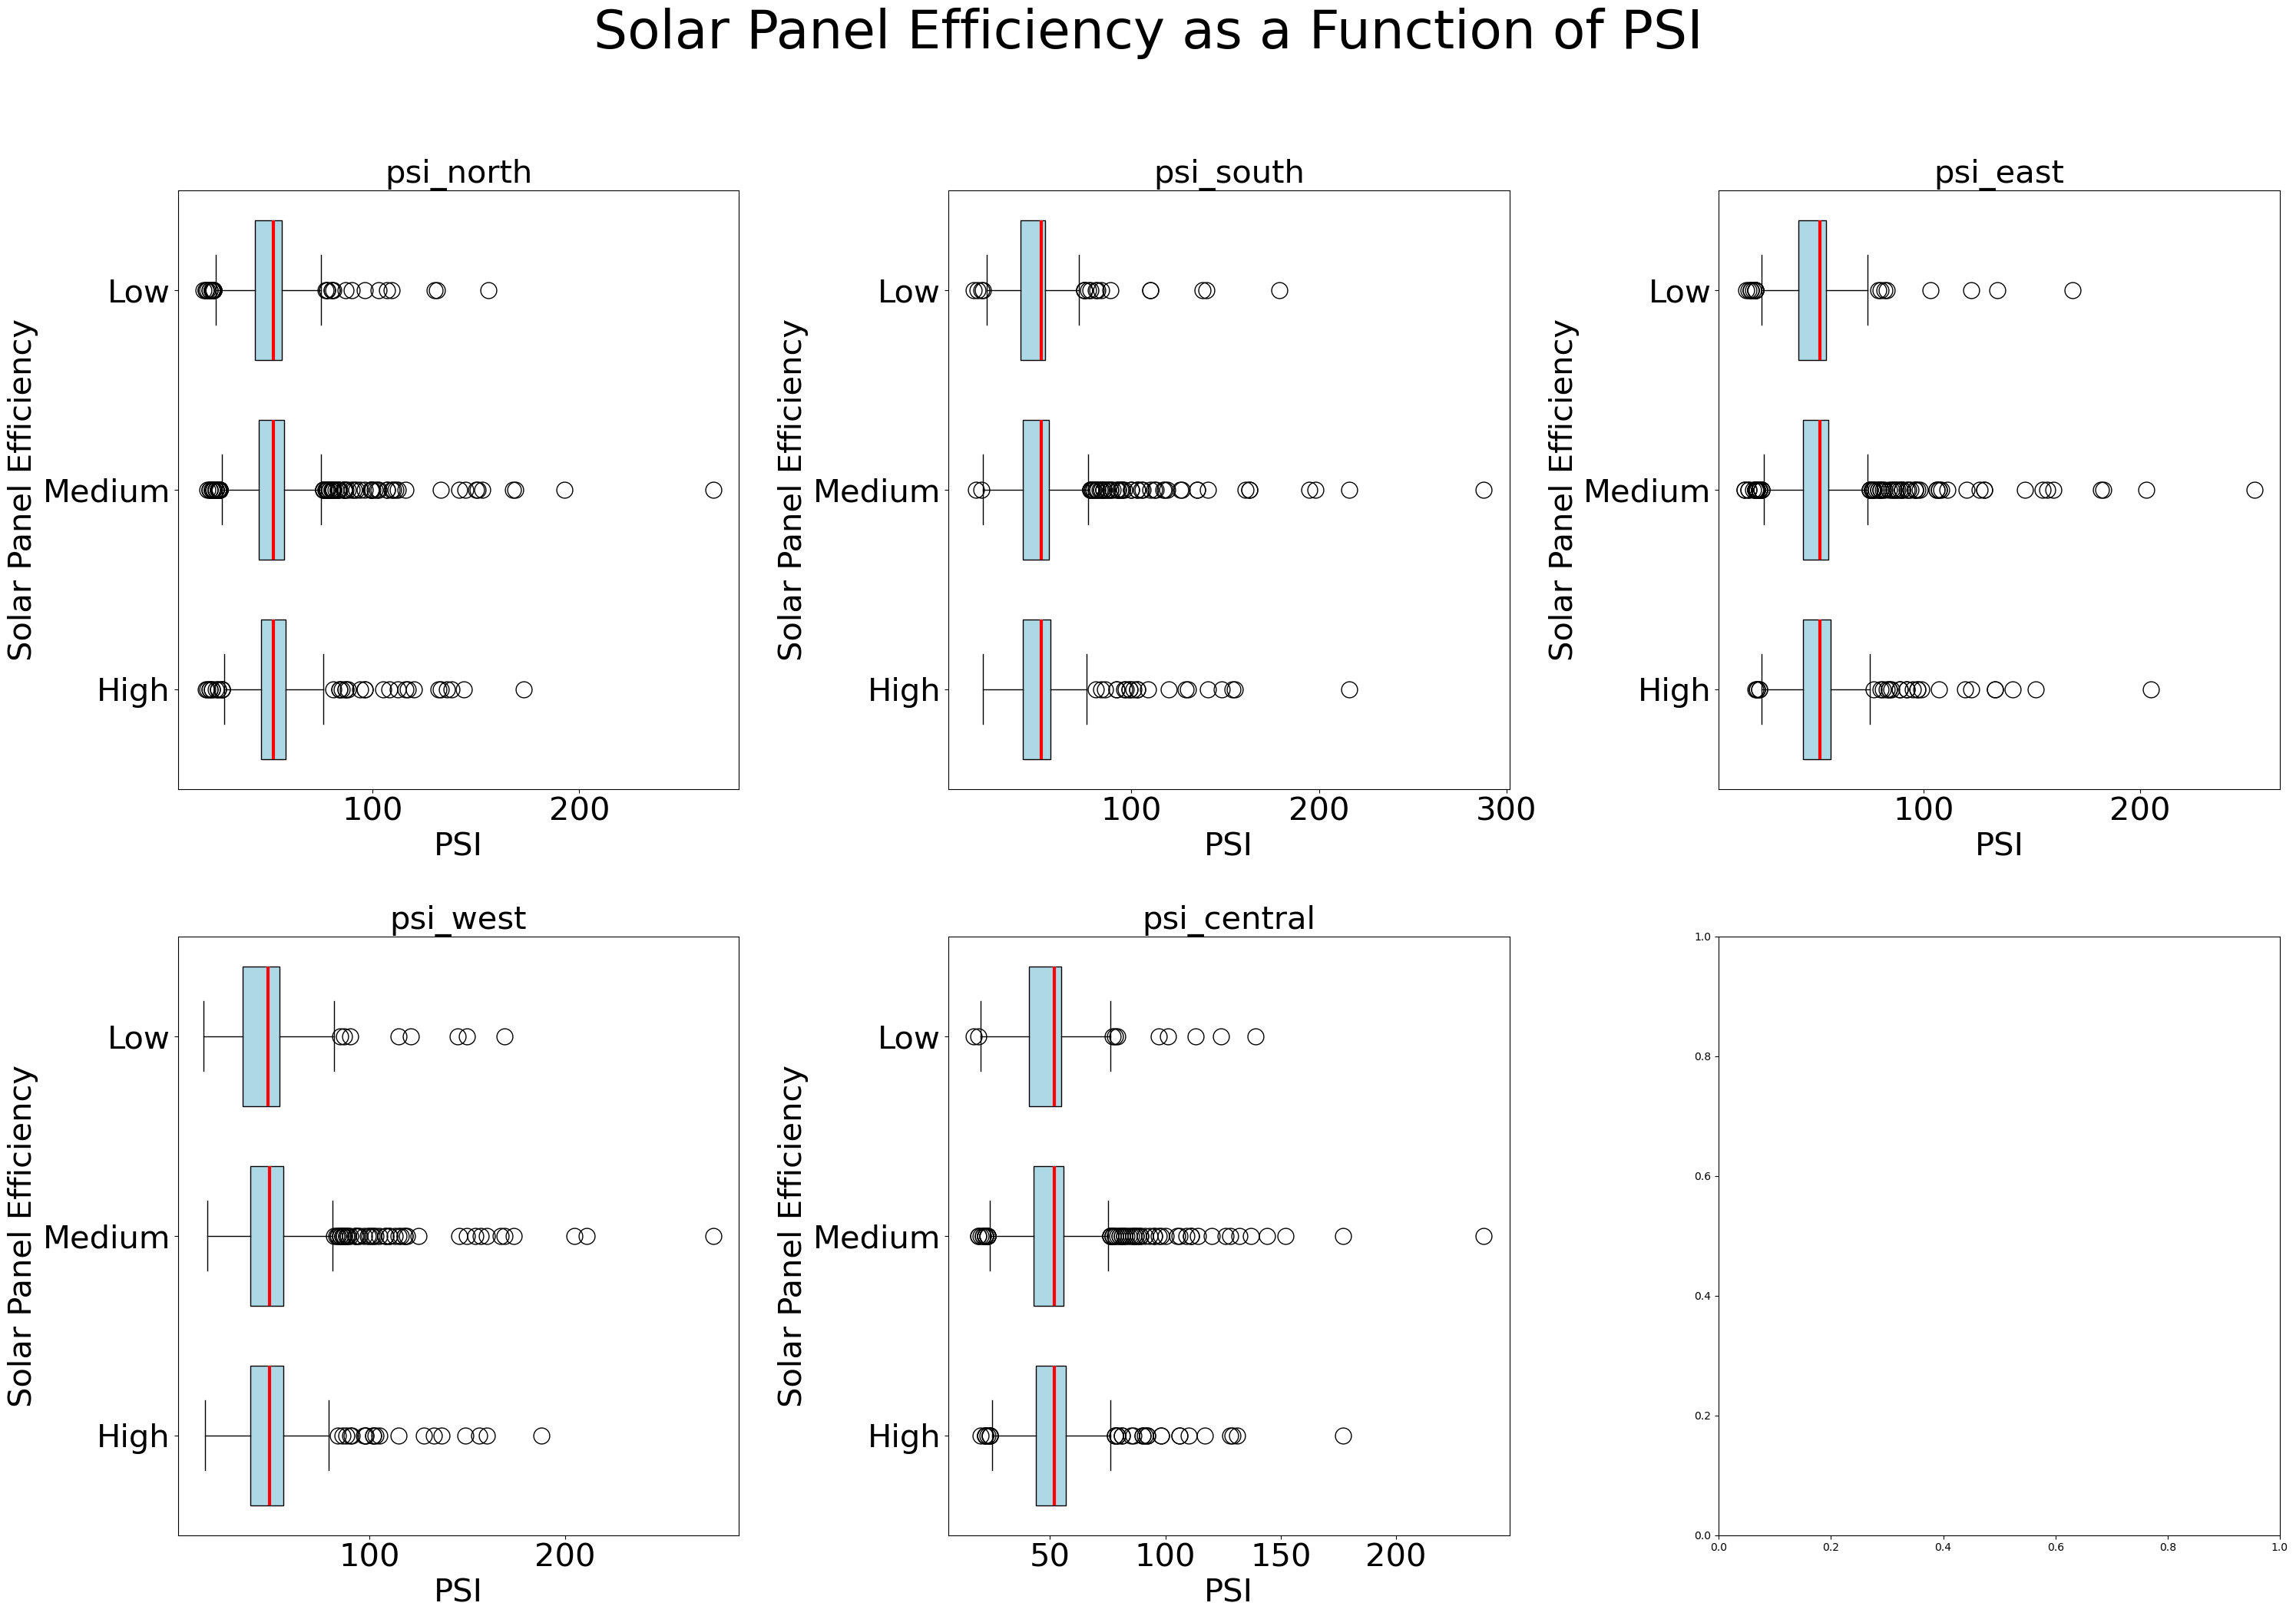

In [208]:
# Visualizing the relationship between Daily Solar Panel Efficiency(Y) and psi features(X).
fig, ax = plt.subplots(2,3, figsize=(30,20))

r, c = 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('psi')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':3, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 15}, vert=False)
    ax[r,c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':30})
    ax[r,c].set_yticklabels(labels, fontsize=30)
    ax[r,c].set_xlabel('PSI', fontdict={'fontsize':30})
    ax[r,c].tick_params(axis='x', labelsize=30)
    ax[r,c].set_title(f, fontdict={'fontsize':30})
    
    if c>1:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of PSI', fontsize=50, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

No relationship is observed. The different levels (classes) of Daily Solar Panel Efficiency are not differentially distributed
across the PSI of any direction. This suggests that knowinng the PSI numbers provide little information on the likeihood of
whether the solar panel efficiency on that day is low, medium or high.

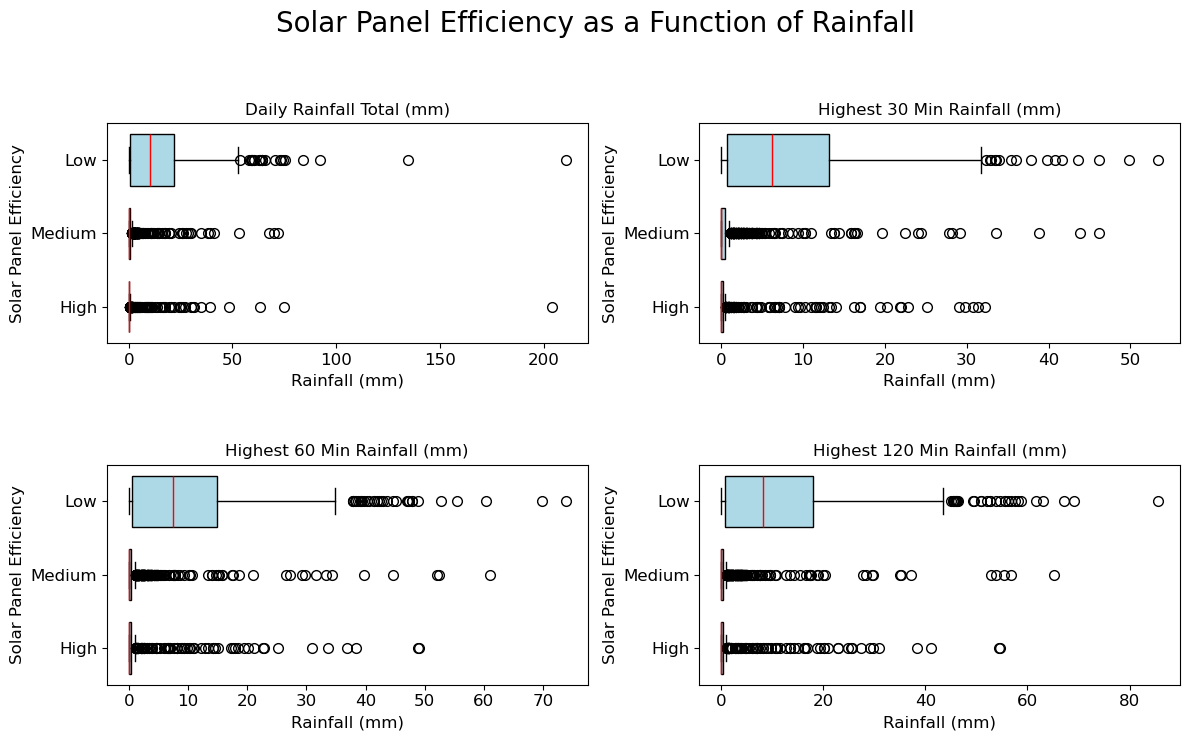

In [209]:
# Visualizing the relationship between Daily Solar Panel Efficiency(Y) and rainfall-related features(X).
fig, ax = plt.subplots(2,2, figsize=(12,7))

r, c = 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('Rainfall')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':1, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 7}, vert=False)
    ax[r,c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':12})
    ax[r,c].set_yticklabels(labels, fontsize=12)
    ax[r,c].set_xlabel('Rainfall (mm)', fontdict={'fontsize':12})
    ax[r,c].tick_params(axis='x', labelsize=12)
    ax[r,c].set_title(f, fontdict={'fontsize':12})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of Rainfall', fontsize=20, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

Some relationship is observed. Low level of Daily Solar Panel Efficiency is differentially distributed from the other 2 levels
across all the rainfall-related variables. Low level efficiency occurs more frequently at higher level of rainfall, as indicated by
its higher median, 75th percentile and wider interquartile range. This suggests that knowinng the rainfall numbers provide useful 
information on the likeihood of whether the solar panel efficiency on that day is low, medium or high.

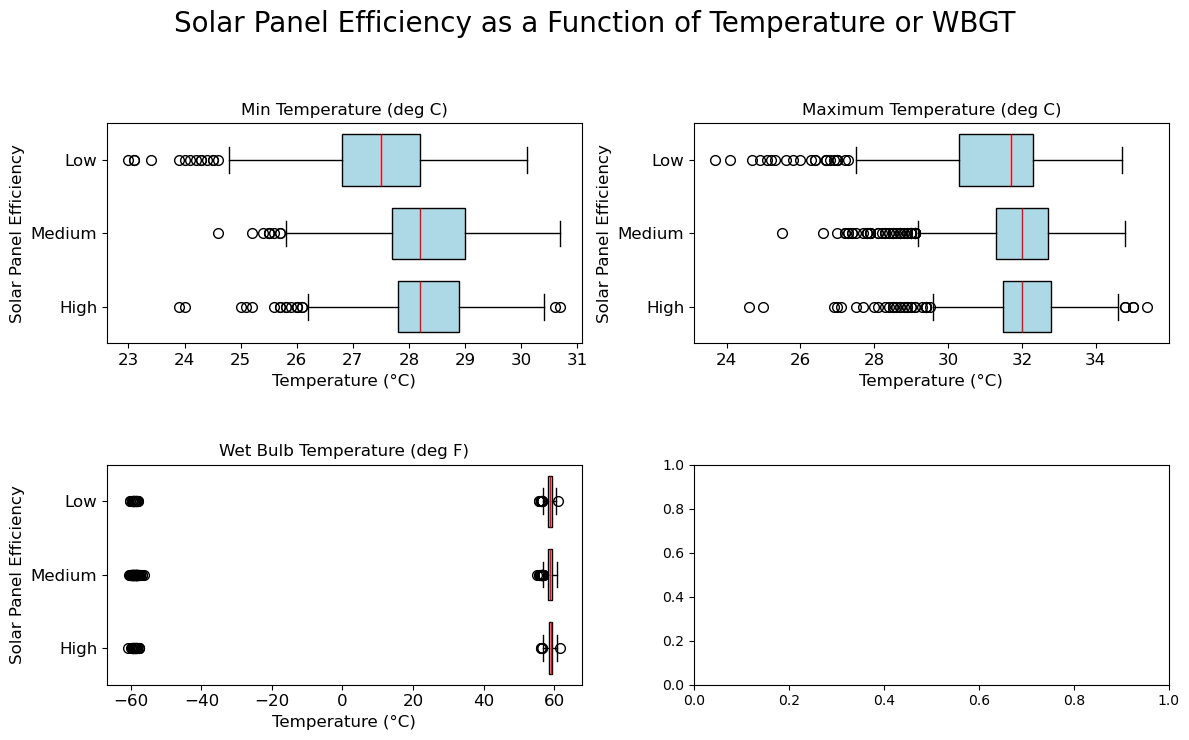

In [210]:
# Visualizing the relationship between Daily Solar Panel Efficiency(Y) and temperature-related and WBGT features(X).
fig, ax = plt.subplots(2,2, figsize=(12,7))

r, c = 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('Temperature')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':1, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 7}, vert=False)
    ax[r,c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':12})
    ax[r,c].set_yticklabels(labels, fontsize=12)
    ax[r,c].set_xlabel('Temperature (°C)', fontdict={'fontsize':12})
    ax[r,c].tick_params(axis='x', labelsize=12)
    ax[r,c].set_title(f, fontdict={'fontsize':12})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of Temperature or WBGT', fontsize=20, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

Some relationship is observed between temperature and Daily Solar Panel Efficiency. Low level of Daily Solar Panel Efficiency is differentially distributed from the other 2 levels across all the temperature-related variables. Low level efficiency occurs more frequently at lower temperature, as indicated by its lower median, 25th and 75th percentiles. This suggests that knowing the either the min or max temperature of the day provide useful information on the likeihood of whether the solar panel efficiency on that day is low, medium or high. However, no relationship is observed for WBGT.

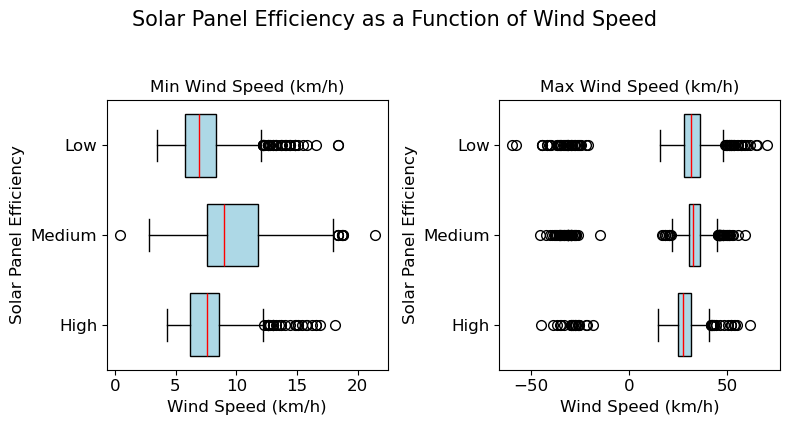

In [211]:
# Visualizing the relationship between Daily Solar Panel Efficiency(Y) and wind speed features(X).
fig, ax = plt.subplots(1,2, figsize=(8,4))

r, c = 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('Wind Speed')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':1, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 7}, vert=False)
    ax[c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':12})
    ax[c].set_yticklabels(labels, fontsize=12)
    ax[c].set_xlabel('Wind Speed (km/h)', fontdict={'fontsize':12})
    ax[c].tick_params(axis='x', labelsize=12)
    ax[c].set_title(f, fontdict={'fontsize':12})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of Wind Speed', fontsize=15, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

Some relationship is observed between wind speed (especially min wind speed) and Daily Solar Panel Efficiency. Medium level of Daily Solar Panel Efficiency is differentially distributed from the other 2 levels across all the wind-related variables. Medium level efficiency occurs more frequently at higher wind speed, as indicated by its higher median, 25th and 75th percentiles. This suggests that knowing the wind speed (especially the min wind speed) of the day provide useful information on the likeihood of whether the solar panel efficiency on that day is low, medium or high.

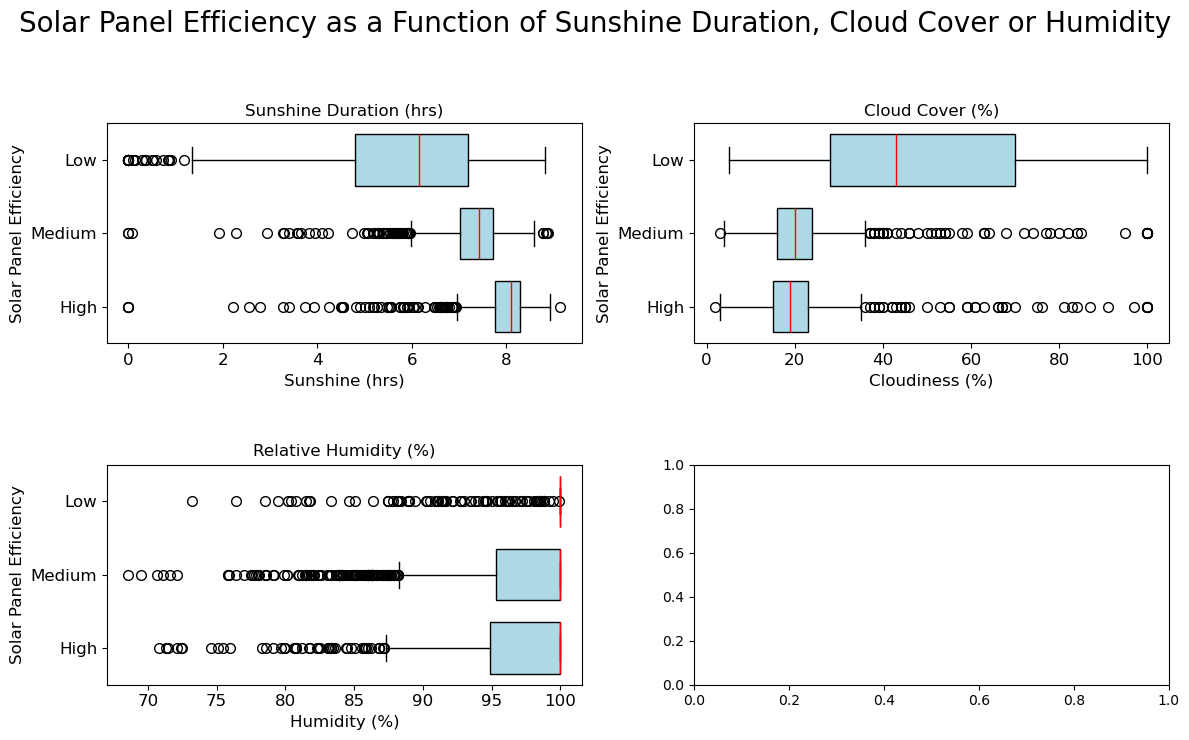

In [212]:
# Visualizing the relationship between Daily Solar Panel Efficiency(Y) and sunshine, cloud cover and humidity features(X).
fig, ax = plt.subplots(2,2, figsize=(12,7))

r, c, i = 0, 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()
xlabel = ['Sunshine (hrs)','Cloudiness (%)','Humidity (%)']

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('Cloud|Sunshine|Humidity')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':1, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 7}, vert=False)
    ax[r,c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':12})
    ax[r,c].set_yticklabels(labels, fontsize=12)
    ax[r,c].set_xlabel(xlabel[i], fontdict={'fontsize':12})
    ax[r,c].tick_params(axis='x', labelsize=12)
    ax[r,c].set_title(f, fontdict={'fontsize':12})
    i+=1
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of Sunshine Duration, Cloud Cover or Humidity', fontsize=20, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

Significant relationship is observed between Sunshine Duration and Daily Solar Panel Efficiency. The 3 levels of Daily Solar Panel Efficiency are differentially distributed from each other across Sunshine Duration. Low level efficiency occurs more frequently at shorter sunshine duration. Medium efficiency occur more frequently at moderate sunshine duration, while high efficiency occurs more frequently at longer sunshine duration as indicated by ther median, 25th, 75th percentiles and interquartile ranges. This suggests that knowing the sunshine duration of the day provide very useful information on the likeihood of whether the solar panel efficiency on that day is low, medium or high.

Similar relationship is also observed between Cloud Cover and Daily Solar Panel Efficiency. Low level efficiency occurs more frequently at higher level of cloudiness than medium and high efficiency. However, meidum and high efficiency occur with similar frequency over the same lower range of cloudiness.
This suggest that while cloud cover is useful for predicting low efficiency, it may not be as useful for predicting between medium and high effciency.

Some relationship is observed between Humidity and Daily Solar Panel Efficiency. Although the 3 efficiency levels have the same median, medium and high efficiency have a lower 25th percentile and wider interquartile range indicating that the 2 levels of efficiency occur at lower humidity levels more frequently than low efficiency. This may be useful for predicting low efficiency.

**3.3 Relationship between Daily Solar Panel Efficiency(Y) and categorical features(X).**

In [213]:
# Apply functions to rename and regroup Dew Point Category & Wind Direction.
merged['Dew Point Category'] = merged['Dew Point Category'].apply(rename_dew_pt)
merged['Wind Direction'] = merged['Wind Direction'].apply(rename_wind_dir)

In [214]:
# Dew Point Category is regrouped into 3 classes, Low, Moderate & High.
merged['Dew Point Category'].value_counts()

Dew Point Category
High        2821
Low          240
Moderate     136
Name: count, dtype: int64

In [215]:
merged['Wind Direction'].value_counts()

Wind Direction
SouthEast    457
NorthWest    403
North        403
NorthEast    402
West         395
SouthWest    388
South        381
East         368
Name: count, dtype: int64

In [216]:
# Create a table to get the counts of each level of Daily Solar Panel Efficiency in each Dew Point category.
dew_pt = cross_table(merged['Dew Point Category'], merged['Daily Solar Panel Efficiency'])

In [217]:
# Rearrange the columns and rows.
dew_pt = dew_pt[['Low', 'Medium', 'High', 'Total', 'Low(%)', 'Medium(%)', 'High(%)']]
dew_pt = dew_pt.loc[['Low', 'Moderate', 'High'], :]
dew_pt

Daily Solar Panel Efficiency,Low,Medium,High,Total,Low(%),Medium(%),High(%)
Dew Point Category,,,,,,,
Low,62,136,42,240,25.833333,56.666667,17.500000
Moderate,31,69,36,136,22.794118,50.735294,26.470588
High,702,1544,575,2821,24.884793,54.732364,20.382843


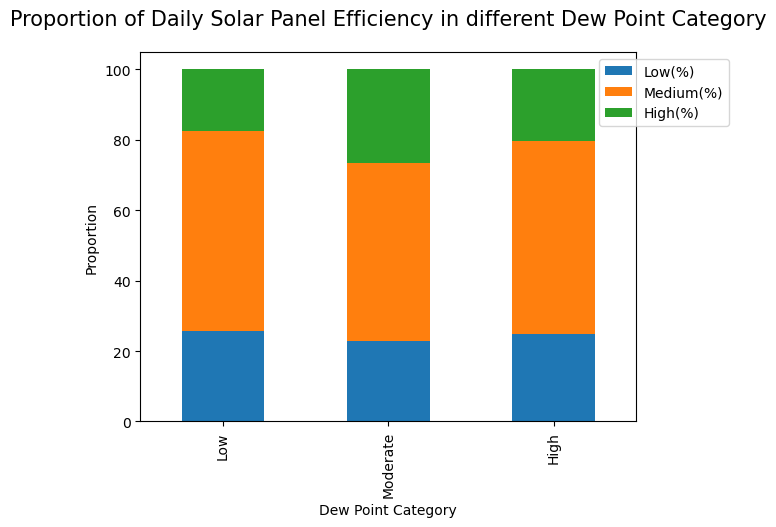

In [218]:
# Stacked barcharts to visualize the distribution of Solar Panel Efficiency levels across different Dew Point categories.
dew_pt.iloc[:,4:].plot(kind='bar', stacked=True)
plt.xlabel('Dew Point Category', fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Proportion of Daily Solar Panel Efficiency in different Dew Point Category", fontsize=15, y=1.05)
plt.xticks(rotation=90)
plt.legend(prop=dict(size=10), loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

To explore if there is a relationship between Daily Solar Panel Efficiency and Dew Point Category, a stacked barchart is used to
look at the proportion of Low, Medium and High efficiency in each of the Dew Point categories. Proportion, instead of raw counts, is plotted
because the number of Low, Moderate and High Dew Point category are different. It would be misleading to just look at the raw counts.

From the barchart, we can see that the proportions of Low, Medium and High Solar Panel Efficiency varies across the different Dew Point categories.
This indicates that a relationship may exist between the 2 variables. This, however, needs to be quantitatively verified by statistical test.
Since both are categorical variables, Chi Square test is used here.

In [219]:
# Chi Square test of independence.
print(stats.chi2_contingency(dew_pt.iloc[:,0:3]))

Chi2ContingencyResult(statistic=4.327755123946161, pvalue=0.36346247854591257, dof=4, expected_freq=array([[  59.68095089,  131.29809196,   49.02095715],
       [  33.81920551,   74.40225211,   27.77854238],
       [ 701.4998436 , 1543.29965593,  576.20050047]]))


With a p-value of more than 0.05, Chi square test results shows that the variations observed are not statistically significant.

In [220]:
# Create a table to get the counts of each level of Daily Solar Panel Efficiency in each Wind Direction.
wind_dir = cross_table(merged['Wind Direction'], merged['Daily Solar Panel Efficiency'])

In [221]:
# Rearrange the rows and columns.
wind_dir = wind_dir[['Low', 'Medium', 'High', 'Total', 'Low(%)', 'Medium(%)', 'High(%)']]
wind_dir = wind_dir.loc[['North', 'South', 'East', 'West', 'NorthEast','NorthWest','SouthEast','SouthWest'], :]
wind_dir

Daily Solar Panel Efficiency,Low,Medium,High,Total,Low(%),Medium(%),High(%)
Wind Direction,,,,,,,
North,108,220,75,403,26.799007,54.590571,18.610422
South,100,208,73,381,26.246719,54.593176,19.160105
East,90,187,91,368,24.456522,50.815217,24.728261
West,93,221,81,395,23.544304,55.949367,20.506329
NorthEast,92,221,89,402,22.885572,54.975124,22.139303
NorthWest,97,226,80,403,24.069479,56.079404,19.851117
SouthEast,122,256,79,457,26.695842,56.017505,17.286652
SouthWest,93,210,85,388,23.969072,54.123711,21.907216


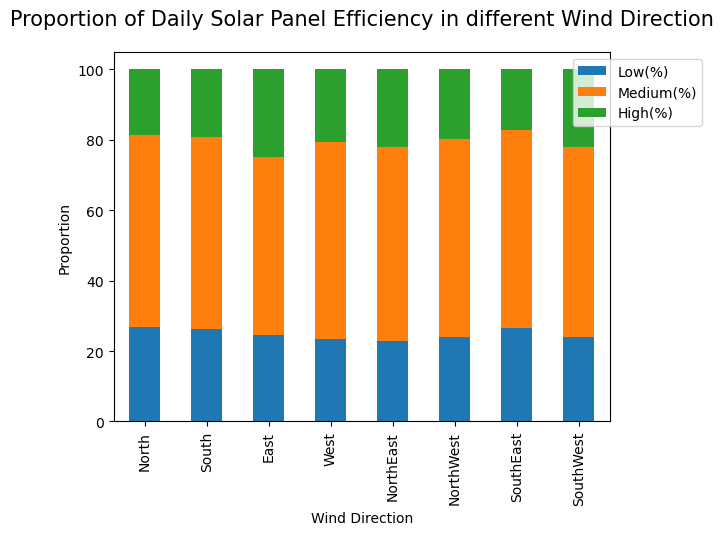

In [222]:
# Stacked barcharts to visualize the distribution of Solar Panel Efficiency levels across different Wind Direction.
wind_dir.iloc[:,4:].plot(kind='bar', stacked=True)
plt.xlabel('Wind Direction', fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Proportion of Daily Solar Panel Efficiency in different Wind Direction", fontsize=15, y=1.05)
plt.xticks(rotation=90)
plt.legend(prop=dict(size=10), loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

To explore if there is a relationship between Daily Solar Panel Efficiency and Wind Direction, a stacked barchart is used to look at the proportion of Low, Medium and High efficiency in each of the Wind Direction. Proportion, instead of raw counts, is plotted because the numbers are different across the different directions. It would be misleading to just look at the raw counts.

From the barchart, we can see that the proportions of Low, Medium and High Solar Panel Efficiency varies across the differenwind directionses. This indicates that a relationship may exist between the 2 variables. This, however, needs to be quantitatively verified by statistical test. Since both are categorical variables, Chi Square test is used here.

In [223]:
# Chi Square test.
print(stats.chi2_contingency(wind_dir.iloc[:,0:3]))

Chi2ContingencyResult(statistic=11.671582984626253, pvalue=0.6326584518629166, dof=14, expected_freq=array([[100.21426337, 220.47137942,  82.31435721],
       [ 94.74350954, 208.43572099,  77.82076947],
       [ 91.51079137, 201.32374101,  75.16546763],
       [ 98.22489834, 216.09477635,  80.6803253 ],
       [ 99.96559274, 219.92430404,  82.11010322],
       [100.21426337, 220.47137942,  82.31435721],
       [113.64247732, 250.01345011,  93.34407257],
       [ 96.48420394, 212.26524867,  79.25054739]]))


With a p-value of more than 0.05, Chi square test results shows that the variations observed are not statistically significant.

In [224]:
# Remove negative values from Max Wind Speed and WBGT.
merged = merged.drop(merged.loc[merged['Max Wind Speed (km/h)']<0].index)
merged = merged.drop(merged.loc[merged['Wet Bulb Temperature (deg F)']<0].index)
merged.reset_index(drop=True, inplace=True)

We observed that there are negative values in Mas Wind Speed and WBGT. These are probably errors that need to be removed.

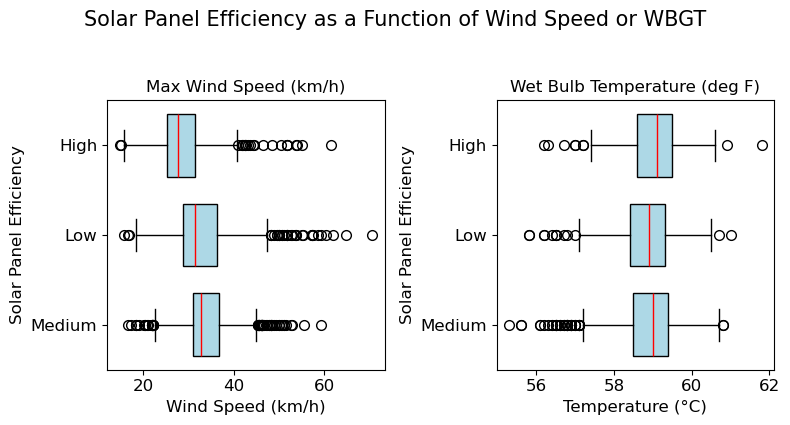

In [225]:
# Relook at the relationship between Max Wind Speed and WBGT with Daily Solar Panel Efficiency.
fig, ax = plt.subplots(1,2, figsize=(8,4))

r, c, i = 0, 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()
xlabel = ['Wind Speed (km/h)', 'Temperature (°C)']

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('Max Wind Speed|Wet')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':1, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 7}, vert=False)
    ax[c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':12})
    ax[c].set_yticklabels(labels, fontsize=12)
    ax[c].set_xlabel(xlabel[i], fontdict={'fontsize':12})
    ax[c].tick_params(axis='x', labelsize=12)
    ax[c].set_title(f, fontdict={'fontsize':12})
    i+=1
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of Wind Speed or WBGT', fontsize=15, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

The differential distribution of panel efficiency with Max Wind Speed is clearer after removal of negative values.
However, no different is observed for WBGT.

### **4. Feature Engineering**

In [226]:
# Create additional features from PM25, PSI, Max Temperature, Min temperature, Max Wind Speed and Min Wind Speed.
merged['pm25_average'] = merged[['pm25_north','pm25_south','pm25_east','pm25_west','pm25_central']].mean(axis=1)
merged['psi_average'] = merged[['psi_north','psi_south','psi_east','psi_west','psi_central']].mean(axis=1)
merged['temp_range'] = merged['Maximum Temperature (deg C)']-merged['Min Temperature (deg C)']
merged['wind_range'] = merged['Max Wind Speed (km/h)']-merged['Min Wind Speed (km/h)']

Since PM25 and PSI in different directions are highly correlated, averages of PM25 and PSI can be created.
Max and Min Temperature can be combined to create a temperature range variable.
Likewise, Max and Min Wind Speed can be combined to create a wind speed range variable.

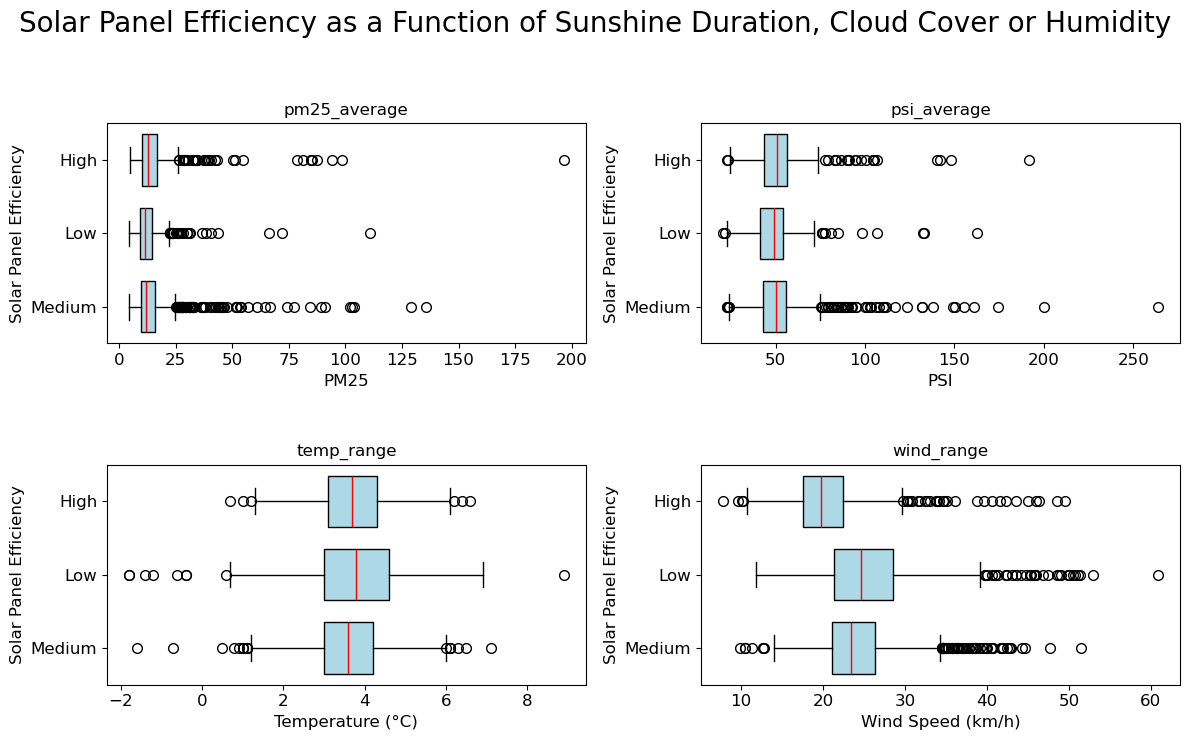

In [227]:
# Explore the relationship of the created variables with Daily Solar Panel Efficiency.
fig, ax = plt.subplots(2,2, figsize=(12,7))

r, c, i = 0, 0, 0

labels = merged['Daily Solar Panel Efficiency'].unique().tolist()
xlabel = ['PM25','PSI','Temperature (°C)','Wind Speed (km/h)']

plt.style.use('default')


for f in merged.loc[:, merged.columns.str.contains('pm25_average|psi_average|temp_range|wind_range')].columns.to_list():
    X = []
    for l in labels:
        x = merged.loc[merged['Daily Solar Panel Efficiency']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, labels=labels, patch_artist=True, medianprops={'linewidth':1, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 7}, vert=False)
    ax[r,c].set_ylabel('Solar Panel Efficiency', fontdict={'fontsize':12})
    ax[r,c].set_yticklabels(labels, fontsize=12)
    ax[r,c].set_xlabel(xlabel[i], fontdict={'fontsize':12})
    ax[r,c].tick_params(axis='x', labelsize=12)
    ax[r,c].set_title(f, fontdict={'fontsize':12})
    i+=1
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Solar Panel Efficiency as a Function of Sunshine Duration, Cloud Cover or Humidity', fontsize=20, y=1.05) 
fig.tight_layout(h_pad=4)
plt.show()

No noticeable relationship can be observed for PM25 Average, PSI Average and Temperature Range. However, some relationship is
observed for Wind Speed Range which displays a pattern of distribution different from Max and Min Wind Speed.

In [228]:
# Final cleaned and processed dataset.
merged

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,...,Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_average,psi_average,temp_range,wind_range
0,2014-04-02,18.0,14.0,12.0,22.0,16.0,57.0,53.0,54.0,61.0,...,59.2,100.0,1005,High,South,Medium,16.4,56.2,3.8,25.1
1,2014-04-03,12.0,12.0,10.0,14.0,10.0,55.0,53.0,52.0,59.0,...,59.7,98.5,1005,Low,East,Medium,11.6,54.6,2.7,35.2
2,2014-04-04,13.0,12.0,24.0,19.0,25.0,58.0,57.0,55.0,49.0,...,59.1,100.0,1011,High,West,Medium,18.6,55.0,3.8,25.7
3,2014-04-05,18.0,19.0,21.0,13.0,17.0,64.0,64.0,66.0,49.0,...,58.9,100.0,1012,High,East,Low,17.6,61.8,1.6,22.7
4,2014-04-06,13.0,11.0,11.0,8.0,11.0,54.0,52.0,55.0,41.0,...,59.1,81.7,1009,High,NorthEast,Low,10.8,50.8,4.5,24.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,2022-12-26,7.0,10.0,14.0,8.0,10.0,31.0,44.0,54.0,32.0,...,57.6,100.0,1005,High,East,Medium,9.8,40.2,4.6,23.7
2919,2022-12-27,6.0,13.0,15.0,8.0,10.0,30.0,51.0,52.0,41.0,...,57.7,93.6,1006,High,South,Medium,10.4,44.0,4.6,23.0
2920,2022-12-28,7.0,12.0,15.0,7.0,11.0,31.0,52.0,52.0,30.0,...,57.3,86.7,1008,High,SouthWest,Medium,10.4,41.4,3.3,22.4
2921,2022-12-29,7.0,11.0,16.0,9.0,12.0,31.0,51.0,56.0,36.0,...,57.3,100.0,1007,High,SouthEast,Low,11.0,43.8,4.0,21.1


This the dataframe of the cleaned and processed dataset.

In [1]:
# Export cleaned dataset to Excel file.
# merged.to_excel('cleaned_table.xlsx', index=False)